In [16]:
include("../pic3d.jl")
using .PIC3D
using PyPlot
using LinearAlgebra
using PyCall
anim =  pyimport("matplotlib.animation");
using BenchmarkTools

In [17]:
function generate_particles!(NP, d)
    num = d / (2*NP / (PIC3D.XL*PIC3D.YL*PIC3D.ZL))
    println(num)
    electrons = PIC3D.Species(q=PIC3D.q_e*num, m=PIC3D.m_e*num)
    ions = PIC3D.Species(q=-PIC3D.q_e*num, m=PIC3D.m_e*num*2000)
    @inbounds for i = 1:NP
        x = [rand()*PIC3D.XL, rand()*PIC3D.YL, rand()*PIC3D.ZL]
        v = [5e5, 0, 0]
        push!(electrons.x, [x...])
        push!(electrons.v, [v...])
        push!(ions.x, [x...])
        push!(ions.v, [v...])
        
        x = [rand()*PIC3D.XL, rand()*PIC3D.YL, rand()*PIC3D.ZL] #[rand()*PIC3D.XL, rand()*PIC3D.YL, rand()*PIC3D.ZL]
        v = [-5e5, 0, 0]
        push!(electrons.x, [x...])
        push!(electrons.v, [v...])
        push!(ions.x, [x...])
        push!(ions.v, [v...])
    end

    return electrons, ions
end

generate_particles! (generic function with 1 method)

In [18]:
function compute_EK_particles(electrons, ions)
    ek = 0
    @inbounds for i in eachindex(electrons.v)
        ek += electrons.m*dot(electrons.v[i], electrons.v[i])
    end
    @inbounds for i in eachindex(ions.v)
        ek += ions.m*dot(ions.v[i], ions.v[i])
    end
    ek = 0.5*ek
    return ek
end

function compute_EK_particles2(electrons, ions, NP, d)
    ek = 0
    @inbounds for i in eachindex(electrons.v)
        ek += electrons.m*dot(electrons.v[i], electrons.v[i])
    end
    @inbounds for i in eachindex(ions.v)
        ek += electrons.m*dot(ions.v[i], ions.v[i])
    end
    ek = 0.5*ek*(d / (2*NP / (PIC3D.Δx*PIC3D.Δy*PIC3D.Δz)))
    return ek
end

function compute_EP_field()
    ep = 0
    @inbounds for k = 1:(PIC3D.NZ-1), j = 1:(PIC3D.NY-1), i = 1:(PIC3D.NX-1)
        ep += PIC3D.Ex[i,j,k]^2 + PIC3D.Ey[i,j,k]^2 + PIC3D.Ez[i,j,k]^2
    end
    ep = 0.5 * PIC3D.ε_0 * ep * PIC3D.Δx*PIC3D.Δy*PIC3D.Δz
    return ep
end


function compute_EP_potential()
    ep = 0
    @inbounds for k = 1:(PIC3D.NZ-1), j = 1:(PIC3D.NY-1), i = 1:(PIC3D.NX-1)
        ep += PIC3D.ρ[i,j,k] * PIC3D.ϕ[i,j,k]
    end
    ep = 0.5* PIC3D.ε_0 *ep
    return ep
end

compute_EP_potential (generic function with 1 method)

In [115]:
NP = 2048 #2048
d = 4.5e9
electrons, ions = generate_particles!(NP, d)
PIC3D.timestep!(electrons, ions)
@btime PIC3D.compute_potential!()

1.0986328125e6
  1.323 ms (0 allocations: 0 bytes)


In [71]:
NP = 2048 #2048
d = 4.5e9
electrons, ions = generate_particles!(NP, d)
PIC3D.timestep!(electrons, ions)
@btime PIC3D.compute_potential!()

1.0986328125e6
  129.400 μs (0 allocations: 0 bytes)


In [23]:
NP = 2048 #2048
d = 4.5e9
electrons, ions = generate_particles!(NP, d)

@btime PIC3D.timestep_multigrid!(electrons, ions)

1.0986328125e6
GS failed to converge, L2 = 0.002645873698605617
GS failed to converge, L2 = 0.0026460502548774053
GS failed to converge, L2 = 0.0026731515773787324
GS failed to converge, L2 = 0.0026642057314192427
  7.290 s (41109 allocations: 3.14 MiB)


In [22]:
size(historyxx)

(120,)

MovieWriter ffmpeg unavailable; using Pillow instead.


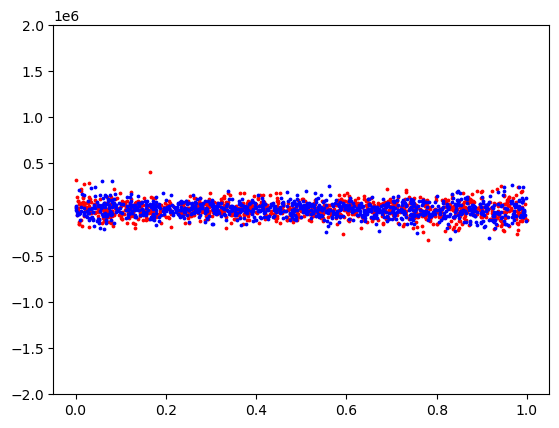

In [20]:
fig = plt.figure()
ax = plt.gca()
ax.set_ylim([-2e6,2e6])
function make_frame(i)
    plt.cla()
 ax.set_ylim([-2e6,2e6])
    firstx = historyxx[i+1][1:2:(size(historyxx[1])[1])]
    firstv = historyvel[i+1][1:2:(size(historyxx[1])[1])]
    plt.scatter([p[1] for p in firstx], [p[1] for p in firstv], s =3, color="red")
    secondx = historyxx[i+1][2:2:(size(historyxx[1])[1] )]
    secondv = historyvel[i+1][2:2:(size(historyxx[1])[1])]
    plt.scatter([p[1] for p in secondx], [p[1] for p in secondv], s =3, color="blue")
end

myanim = anim.FuncAnimation(fig, make_frame, frames=size(historyxx, 1), interval=200, blit=false)
myanim[:save]("tsi2.gif", bitrate=-1)


2.197265625e6
1
GS failed to converge, L2 = 0.0025769200812832374
[-111.03825455627259 -111.09284017261045 -111.10443603526504; -111.08336303566746 -111.0730975202065 -110.9625286503888; -110.97311312177845 -110.94079794653591 -110.87780800604442]
2
GS failed to converge, L2 = 0.0025771587508872664
[-111.05627463920761 -111.10743495830809 -111.11433795025559; -111.10137081556343 -111.08660947317784 -110.97365909042384; -110.9881255033846 -110.95299057312296 -110.8879575060041]
3
GS failed to converge, L2 = 0.0026133100494306265
[-112.60571554644272 -112.65787354873098 -112.66382829509358; -112.65138002566744 -112.63612859748068 -112.52430897807356; -112.53625893460968 -112.50151316260818 -112.43742113797833]
4
GS failed to converge, L2 = 0.002613666072482708
[-112.62159095684048 -112.6747861924981 -112.67968440098763; -112.66784126495963 -112.65210597337872 -112.54121940112063; -112.55094140260955 -112.51656481760007 -112.45318848310228]
5
GS failed to converge, L2 = 0.0026500781617609

Excessive output truncated after 524333 bytes.

GS failed to converge, L2 = 0.002470427332306726
[-106.37254422992747 -106.43269184543739 

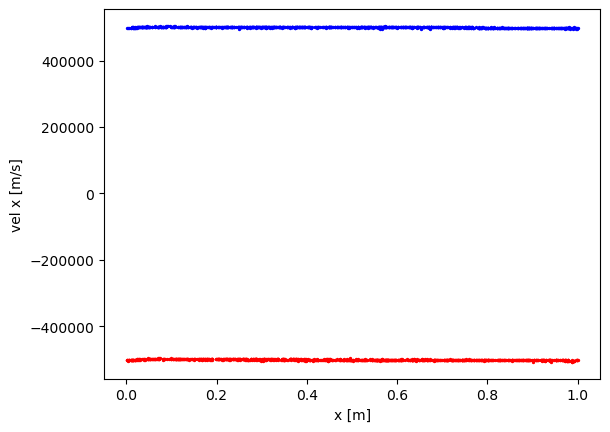

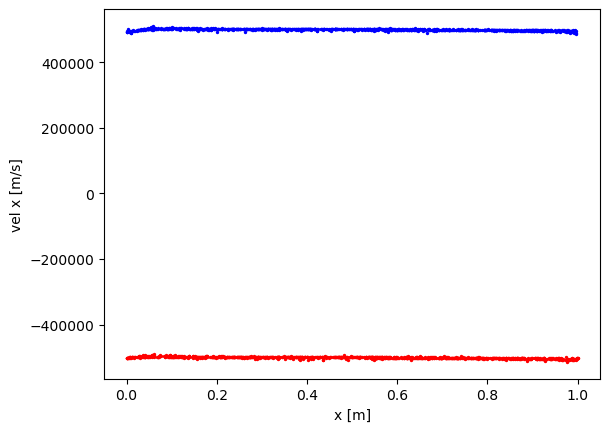

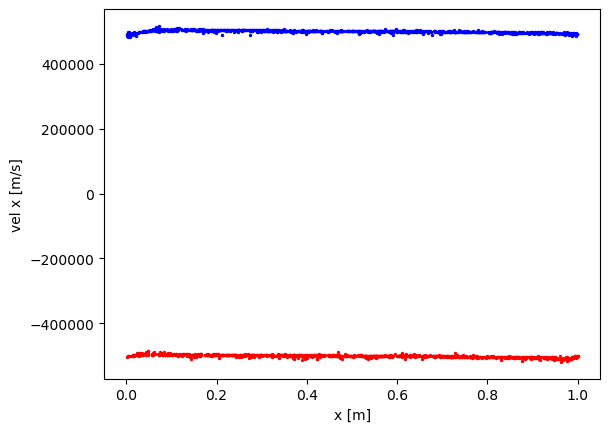

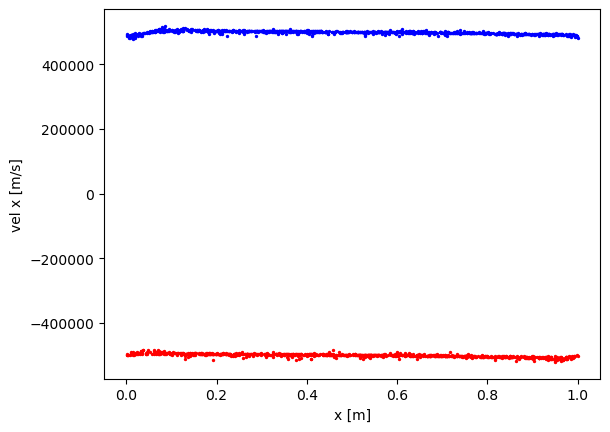

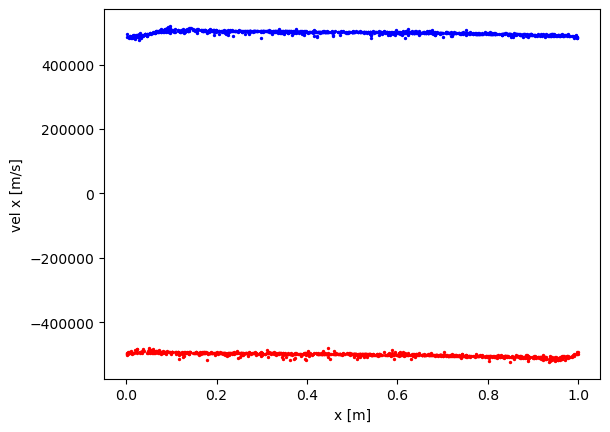

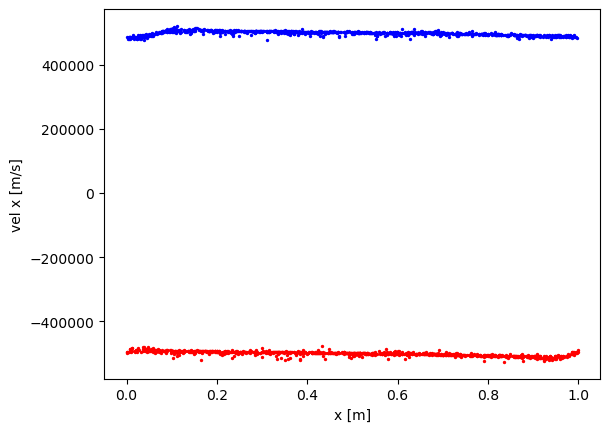

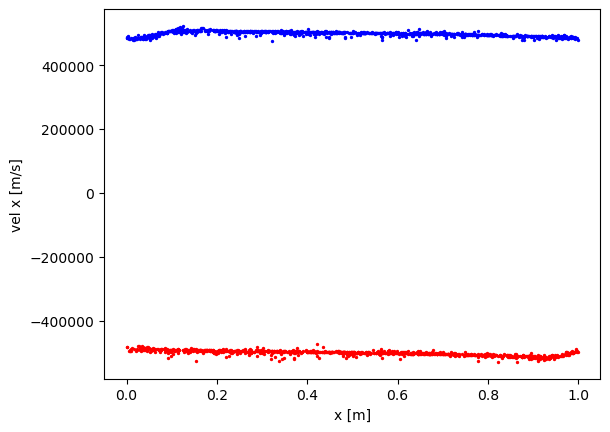

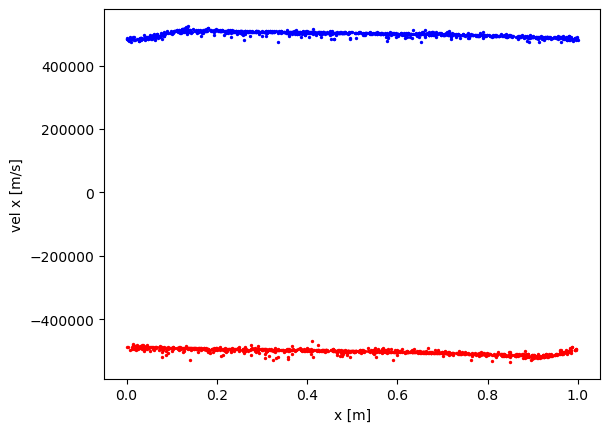

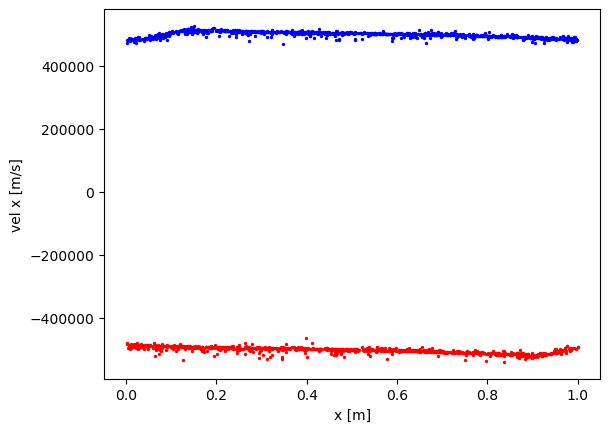

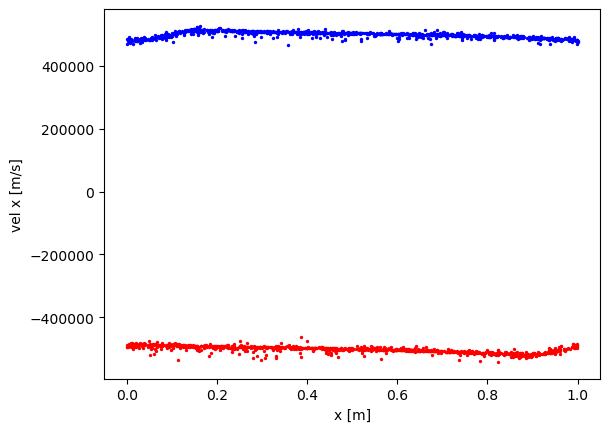

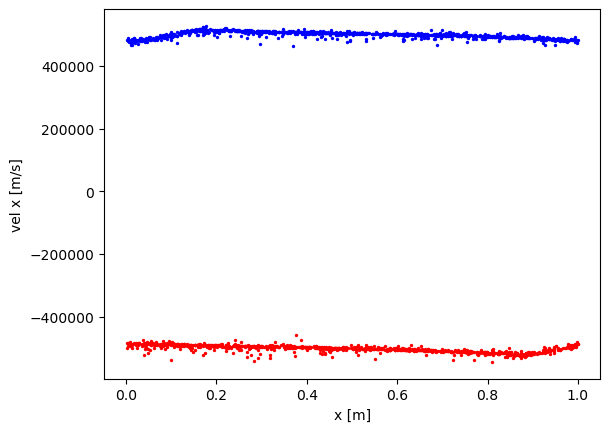

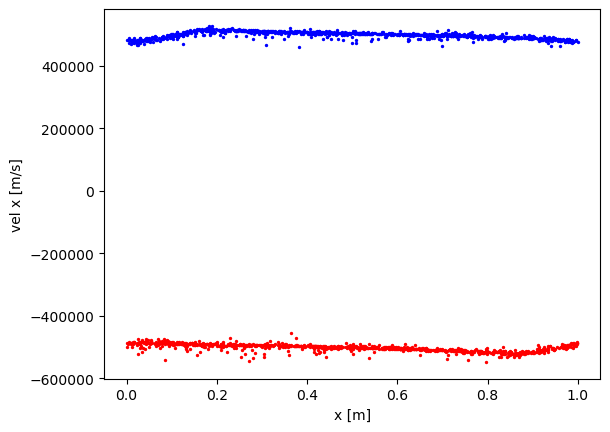

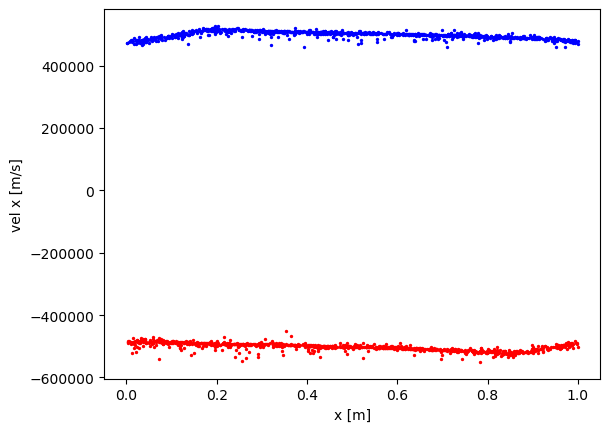

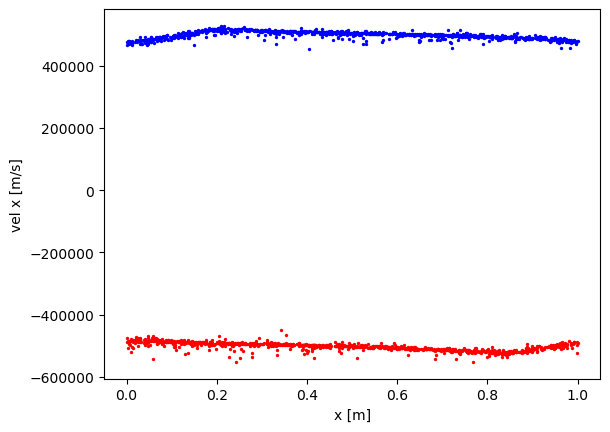

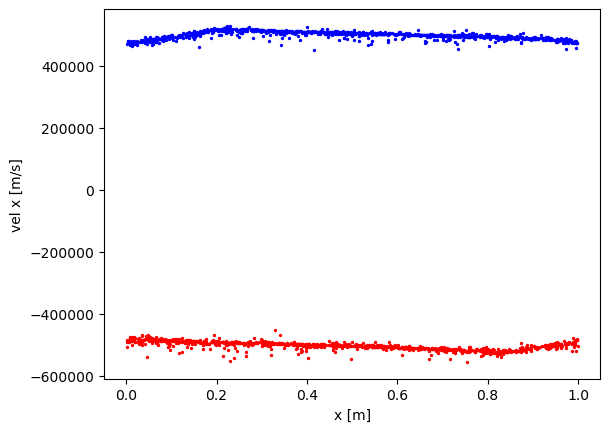

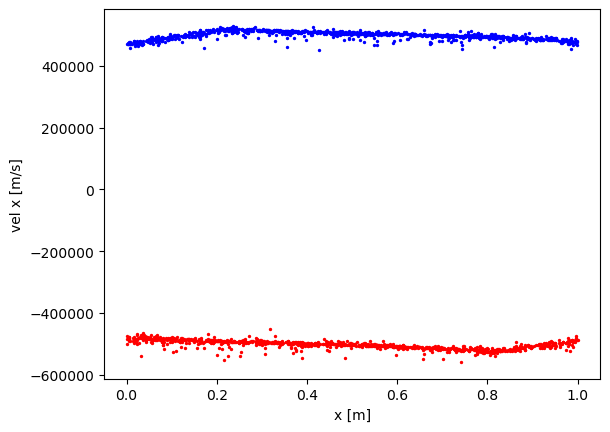

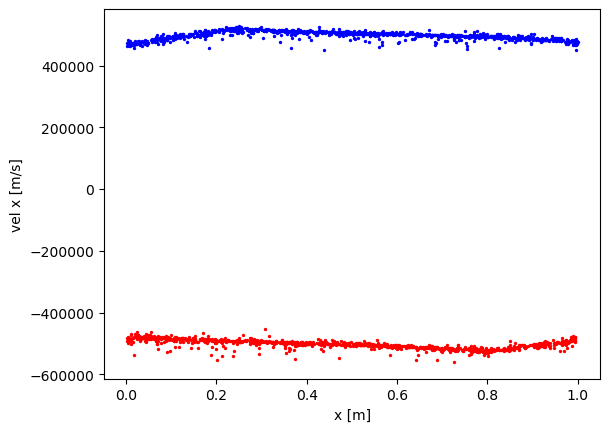

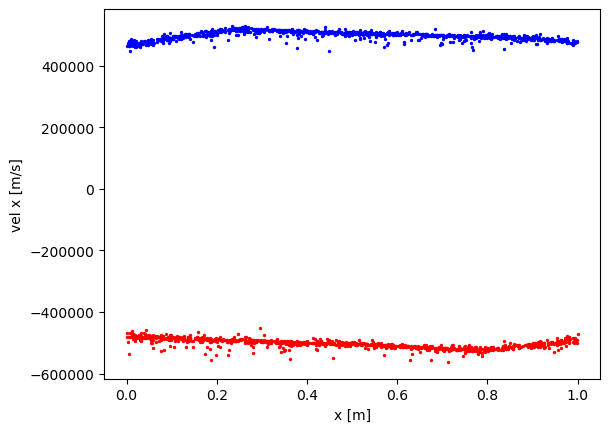

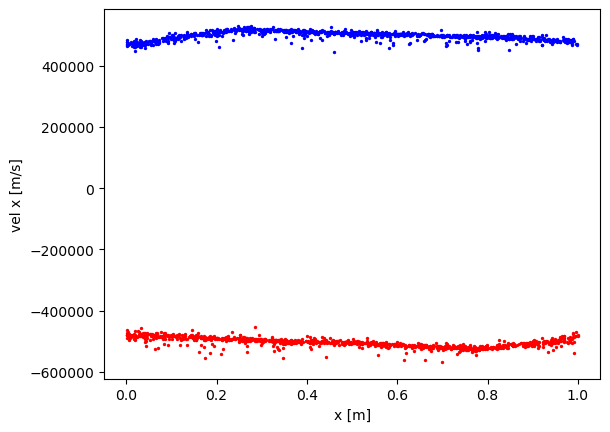

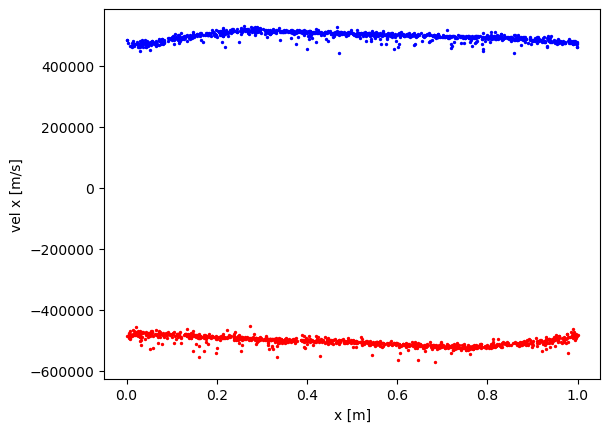

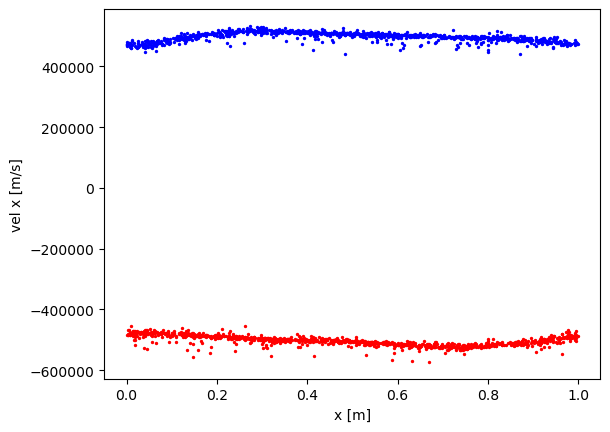

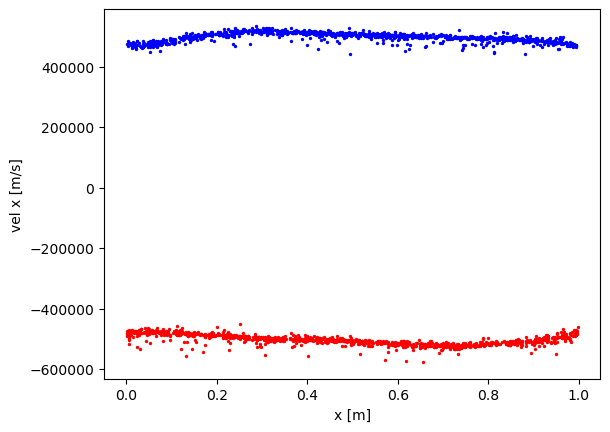

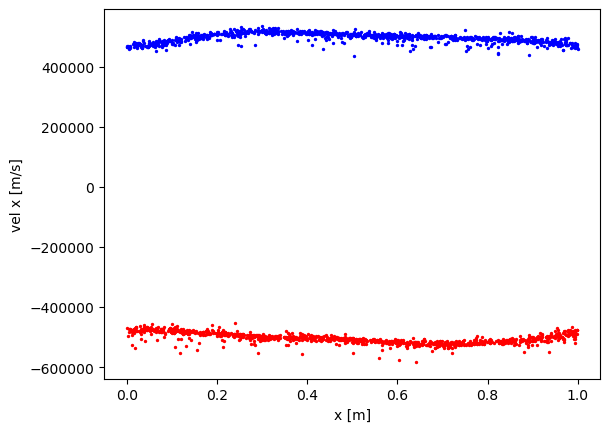

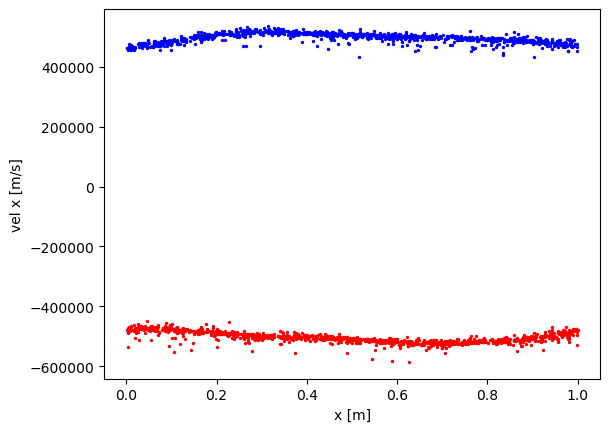

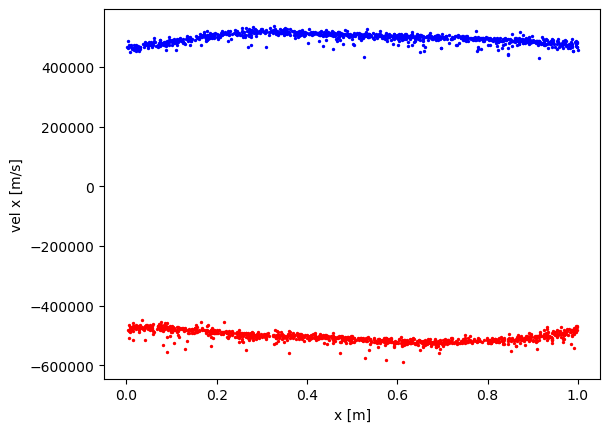

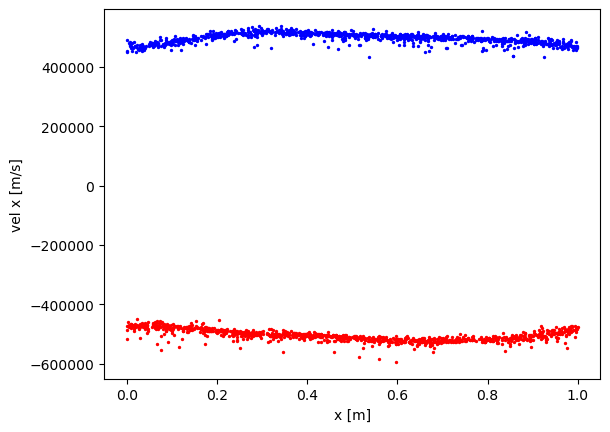

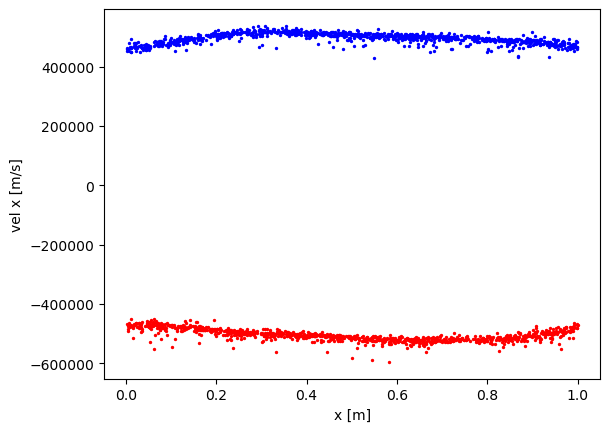

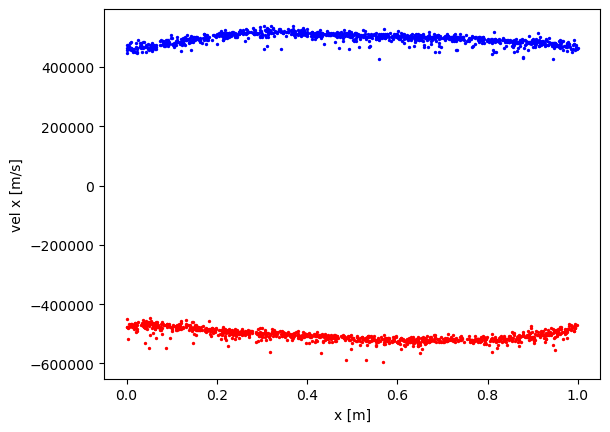

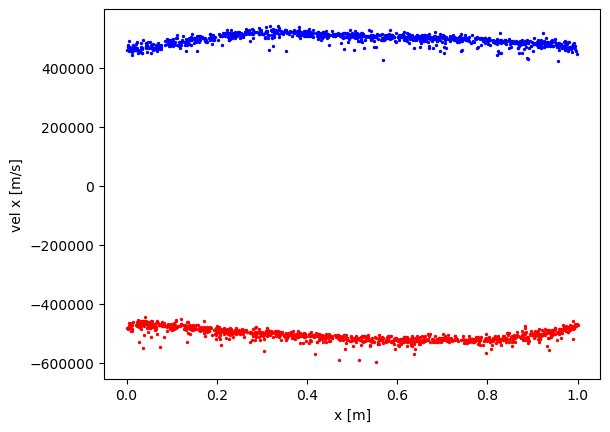

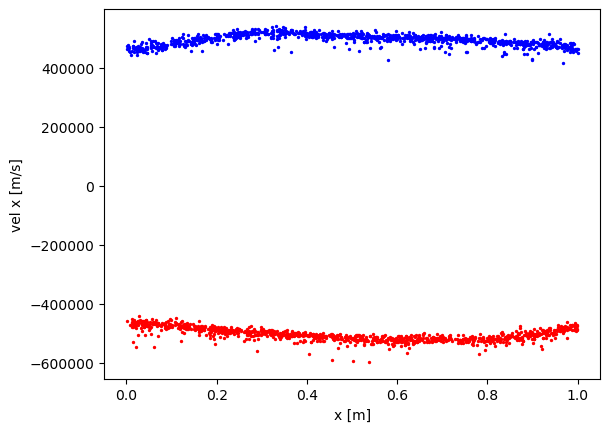

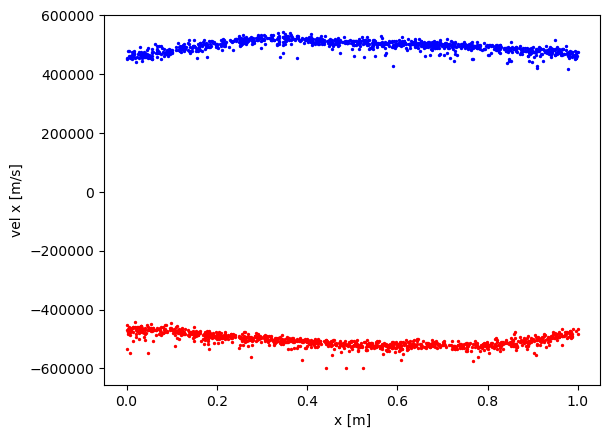

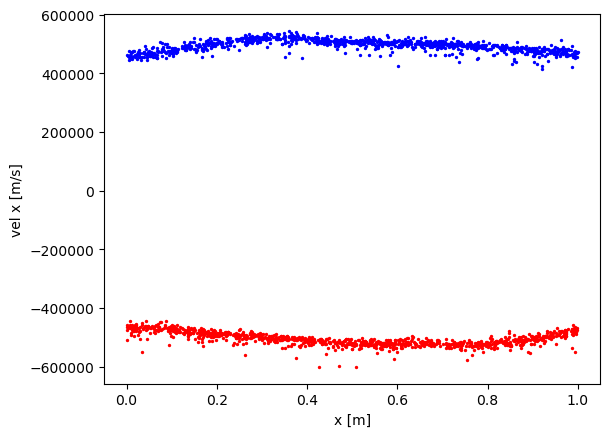

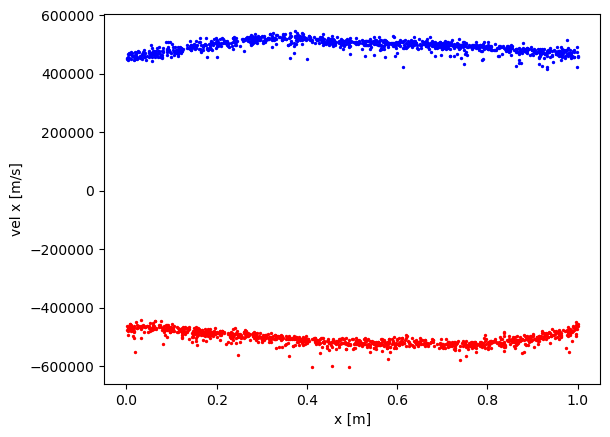

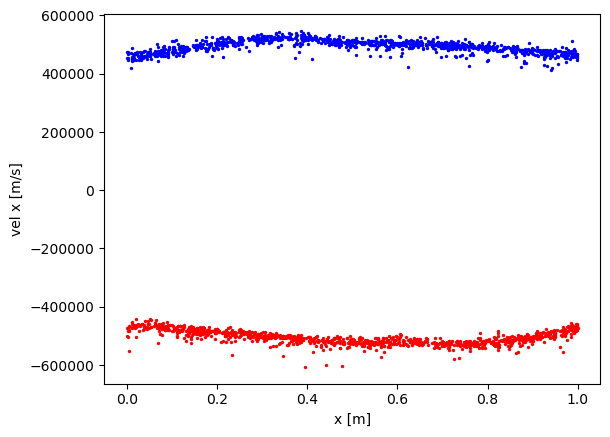

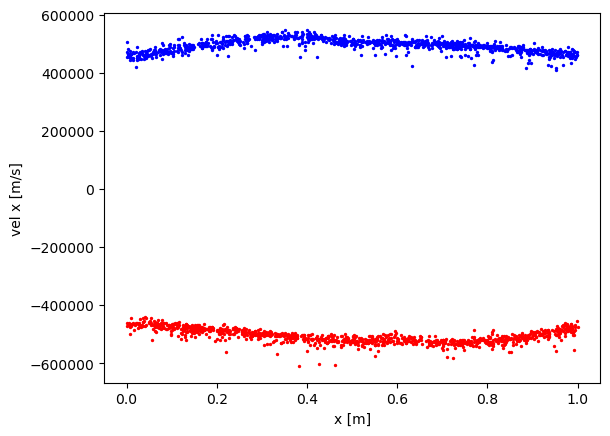

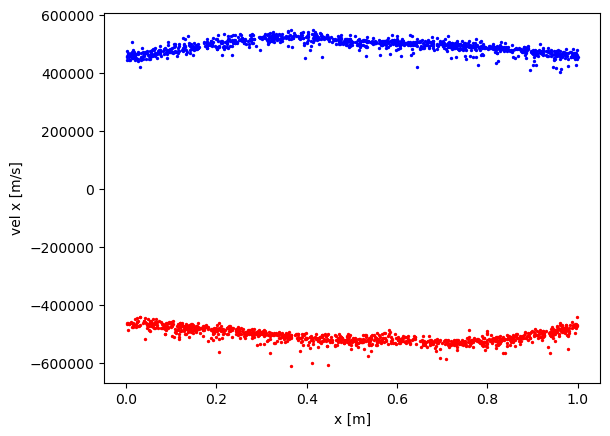

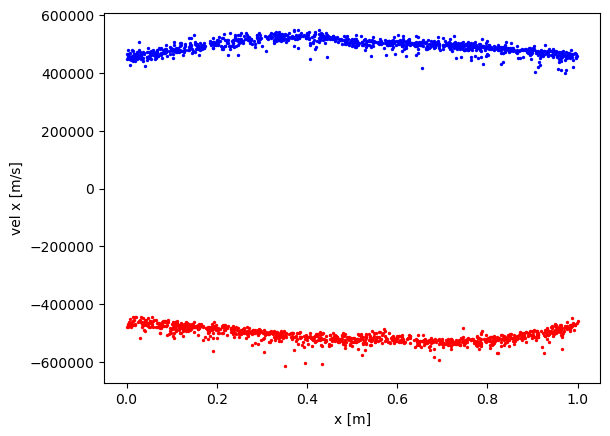

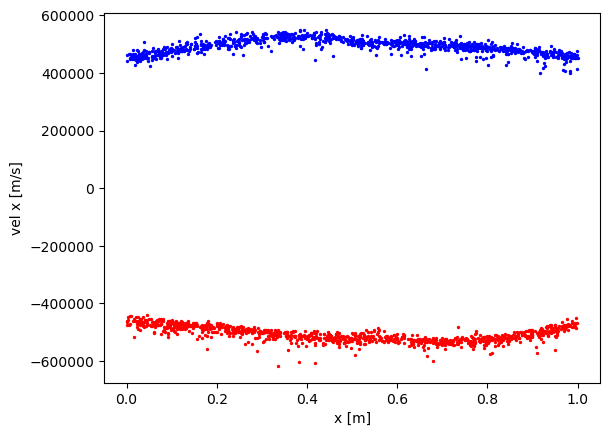

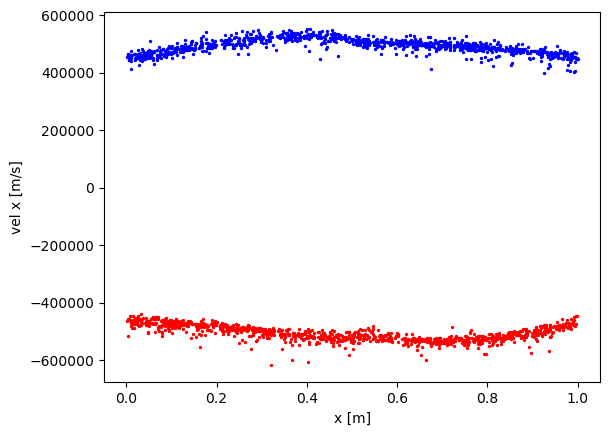

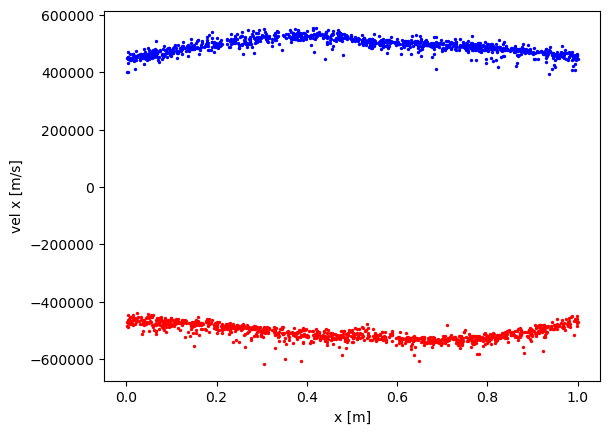

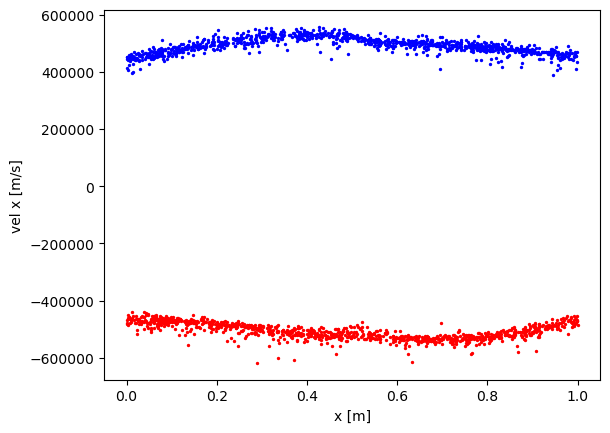

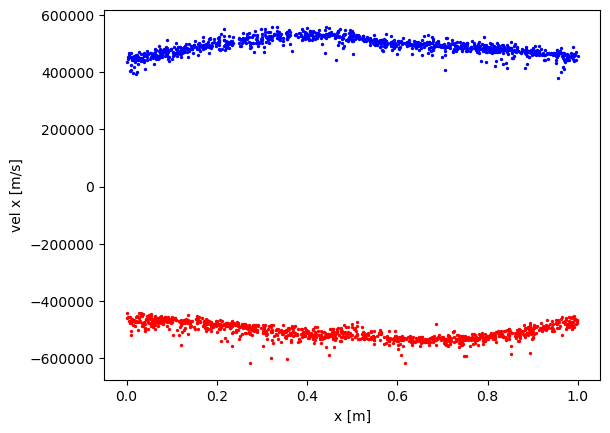

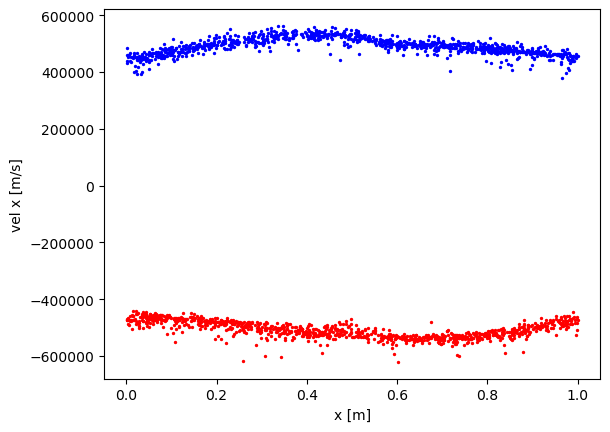

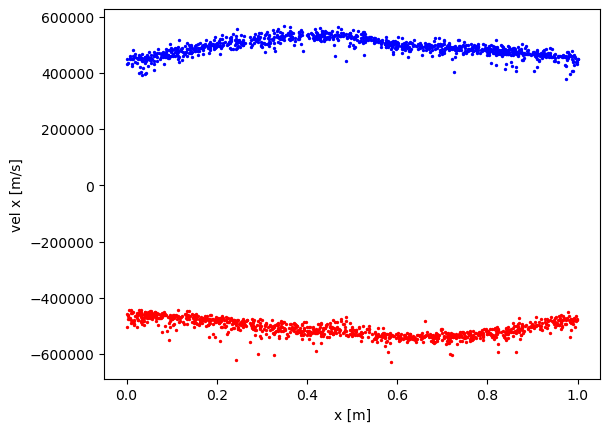

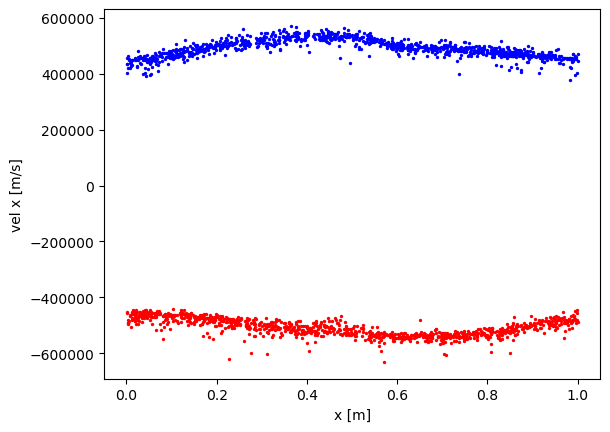

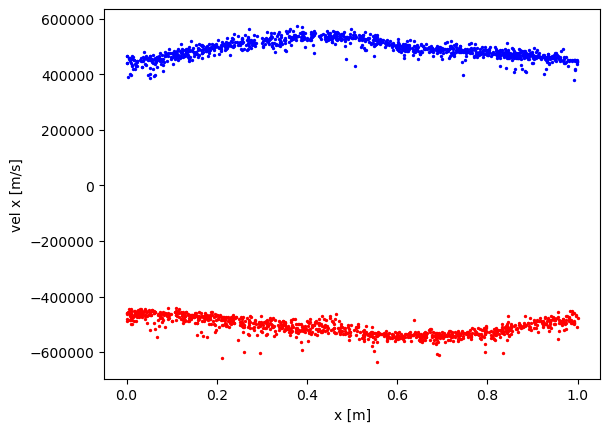

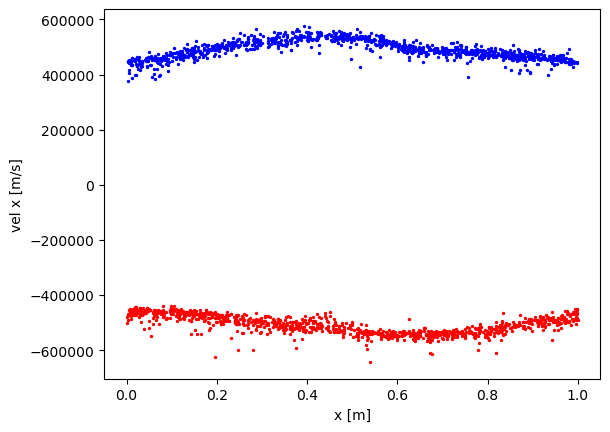

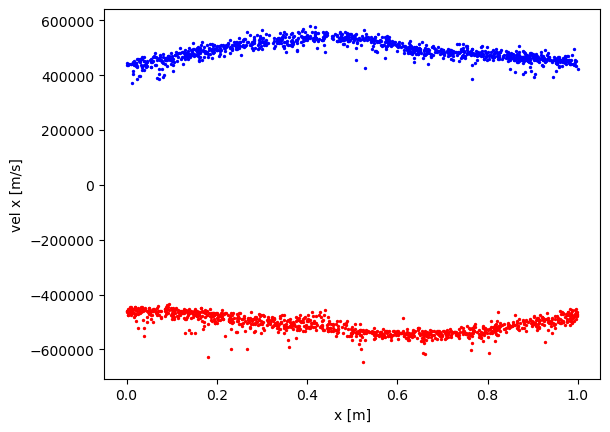

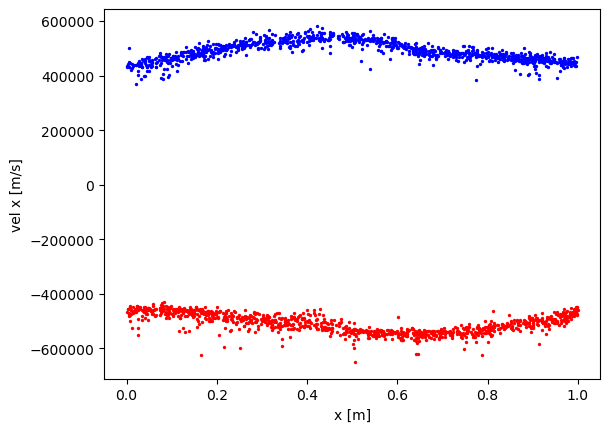

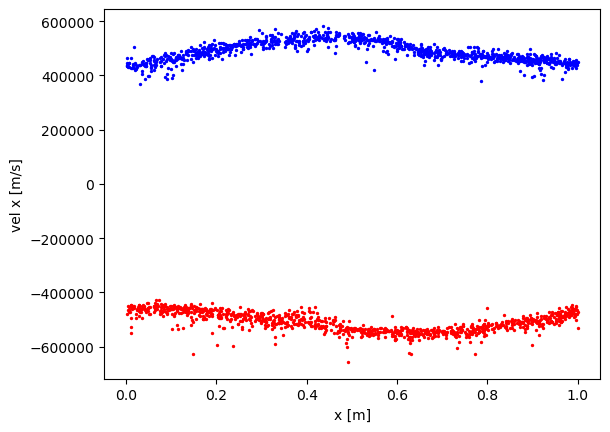

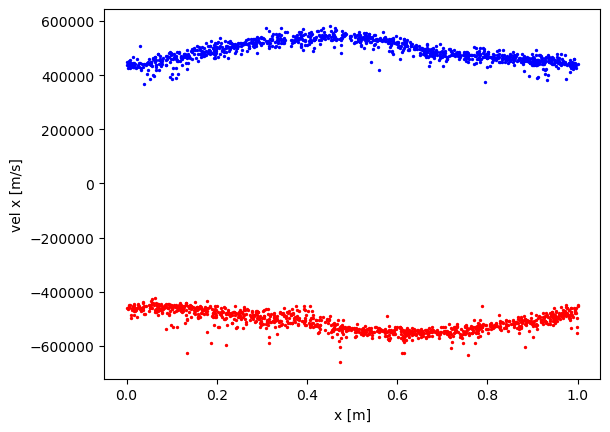

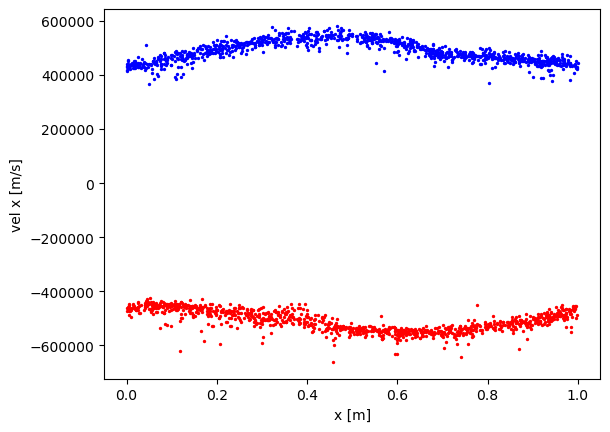

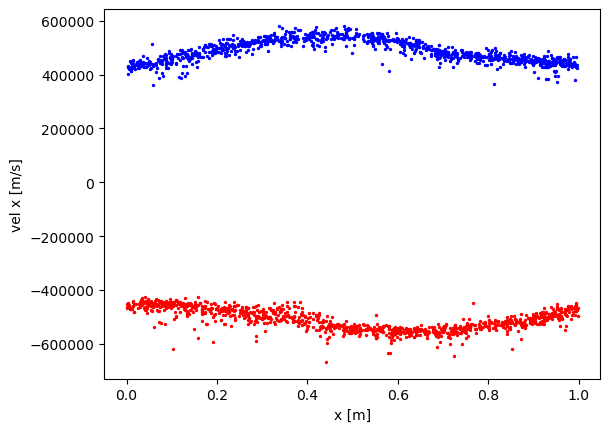

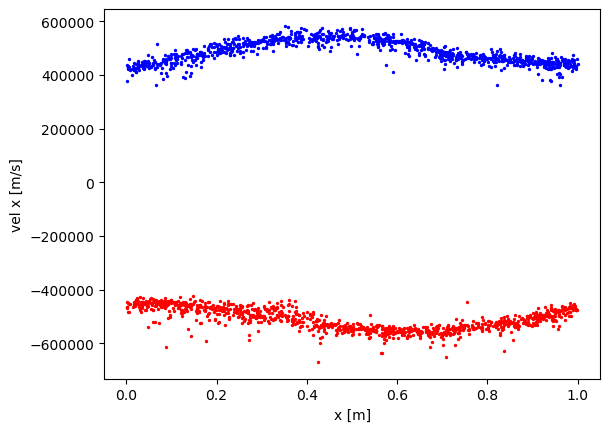

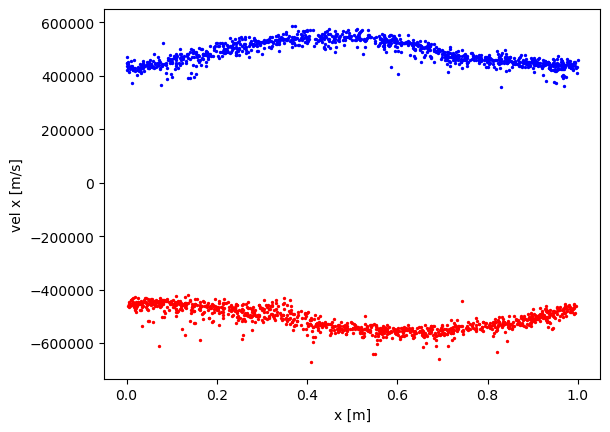

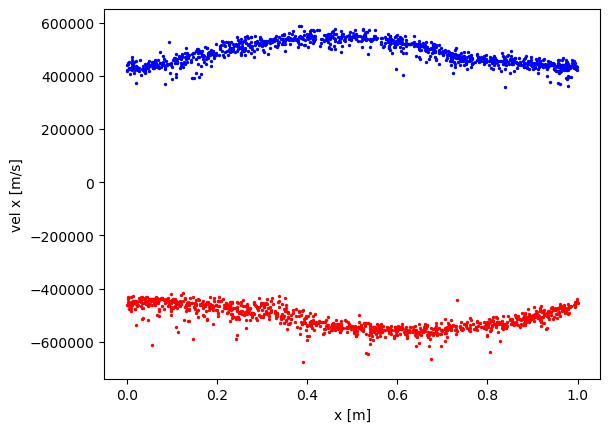

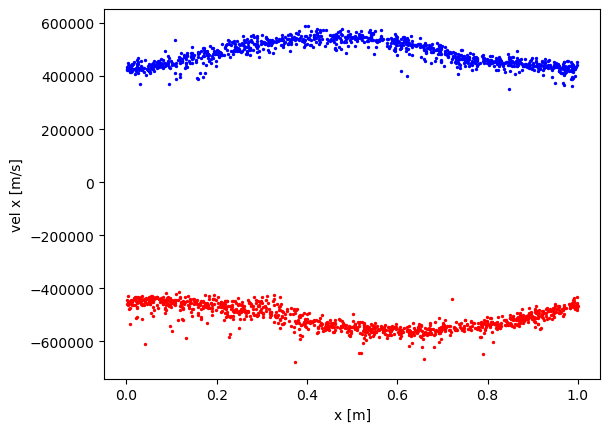

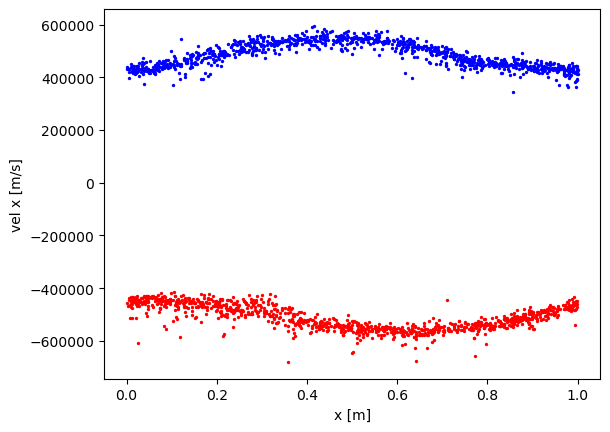

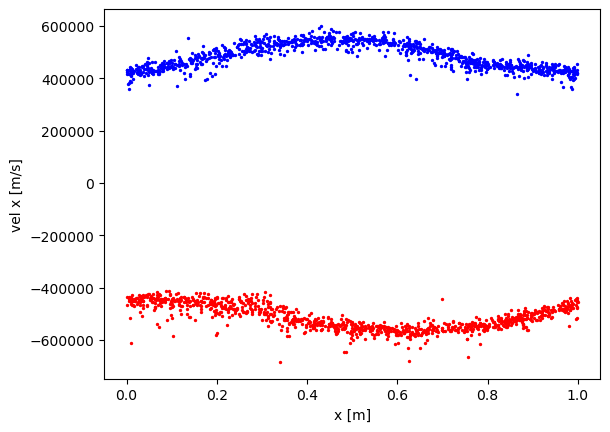

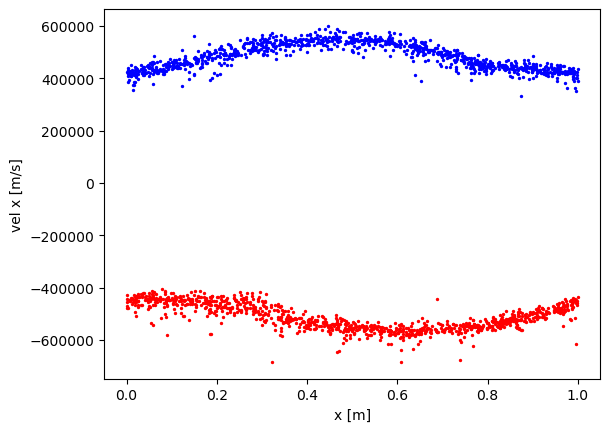

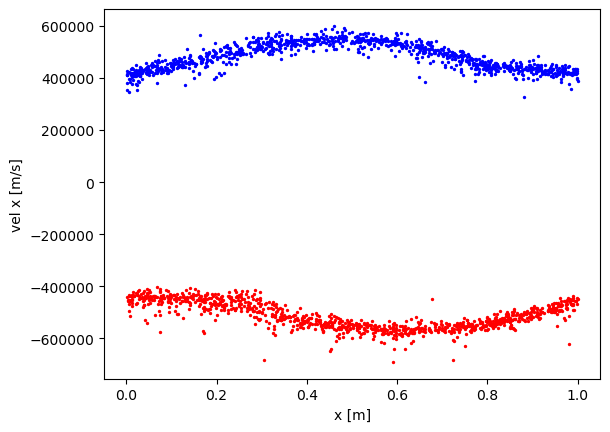

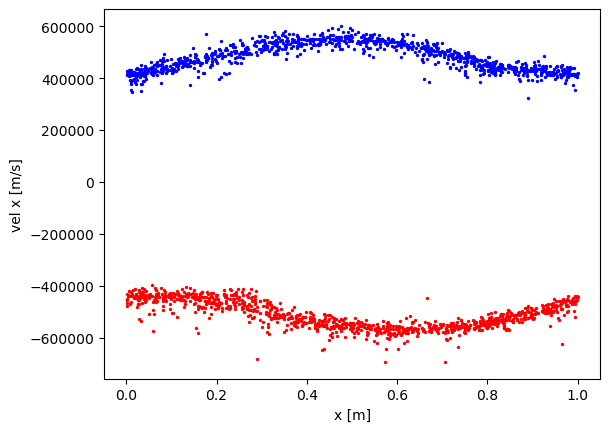

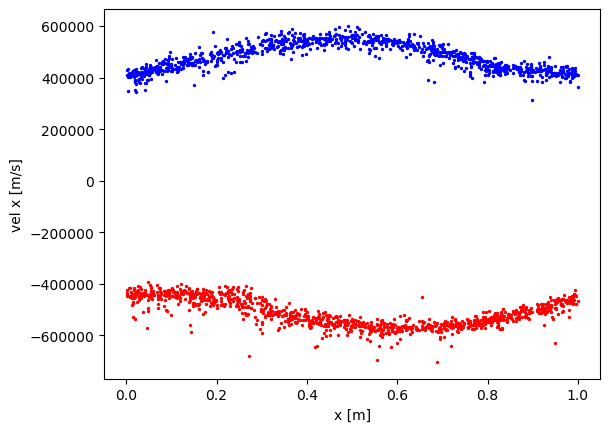

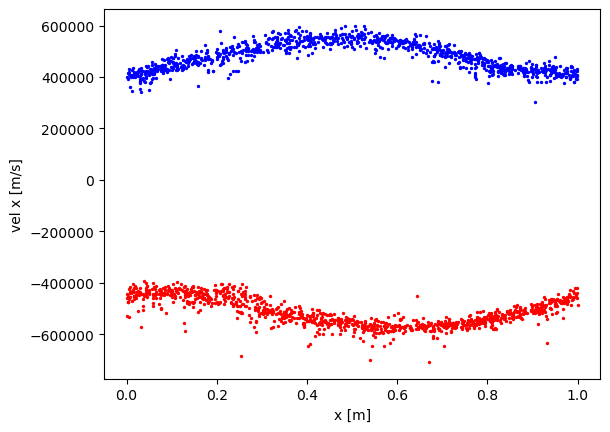

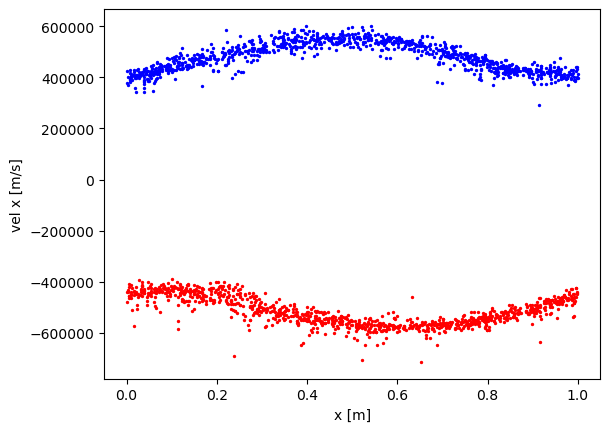

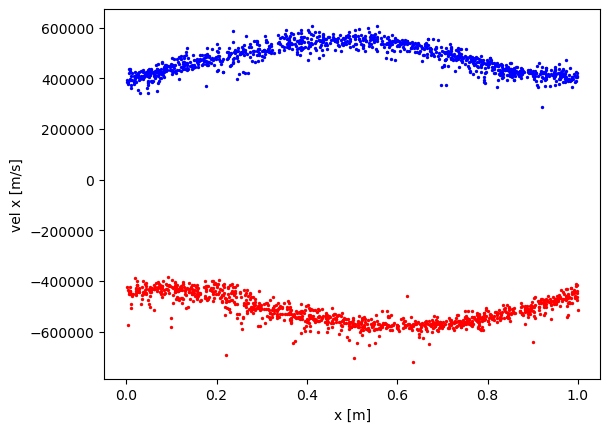

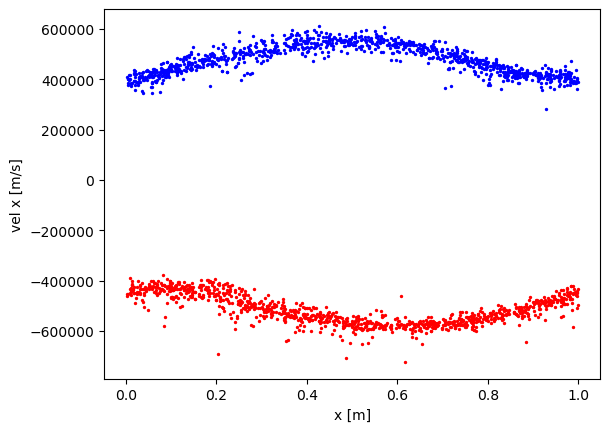

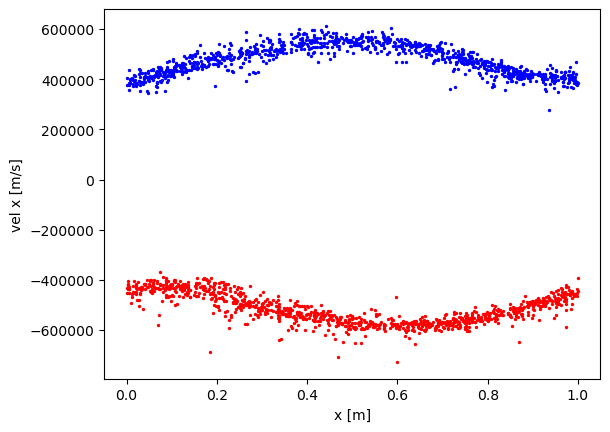

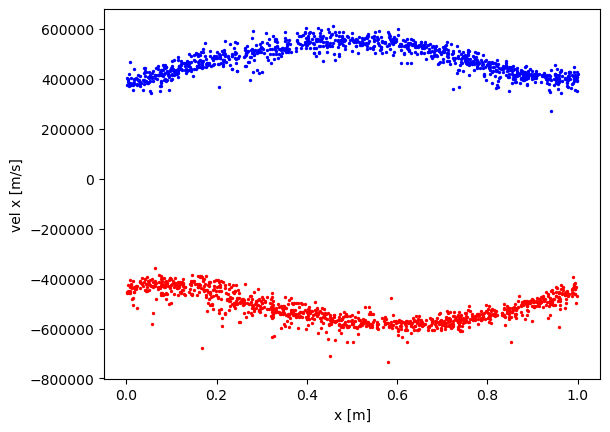

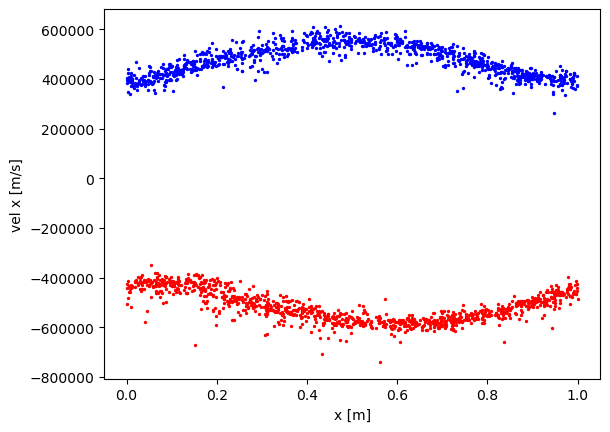

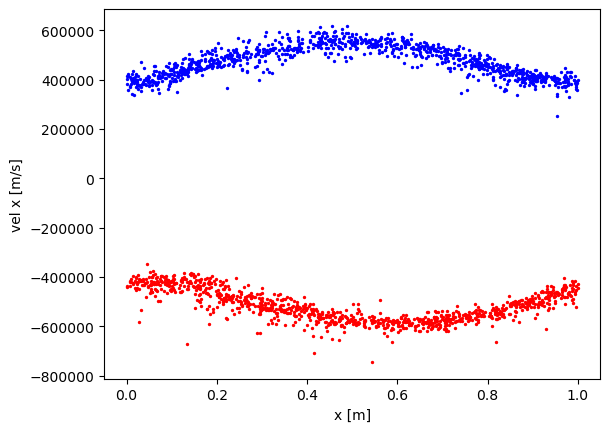

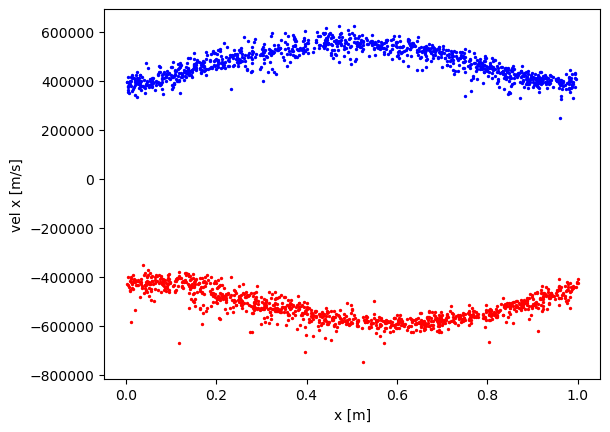

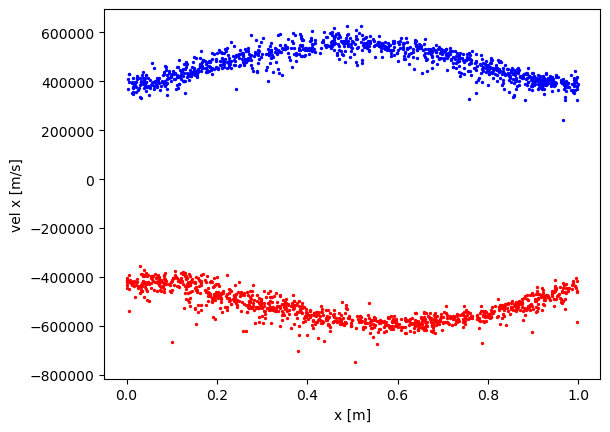

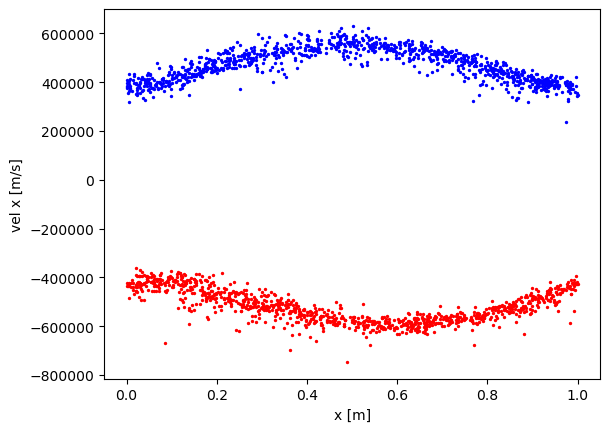

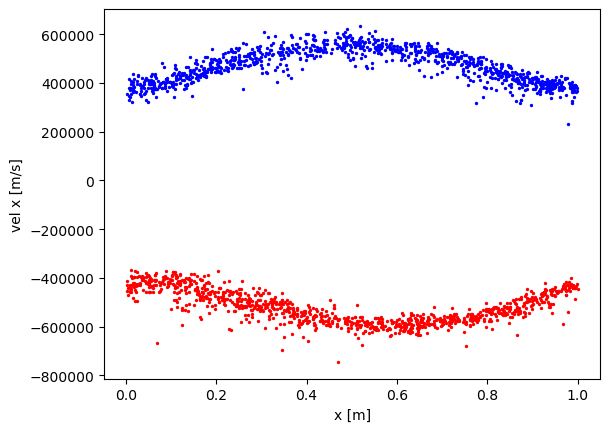

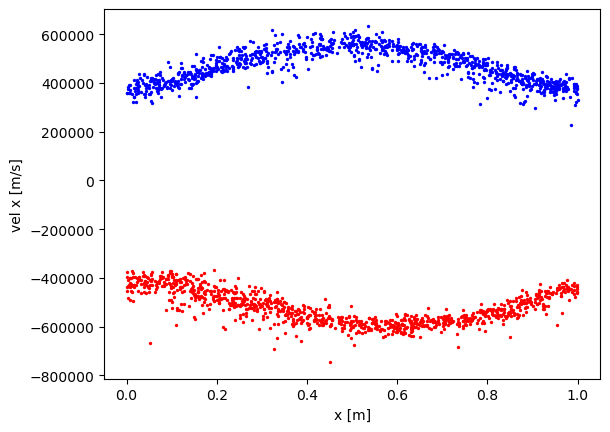

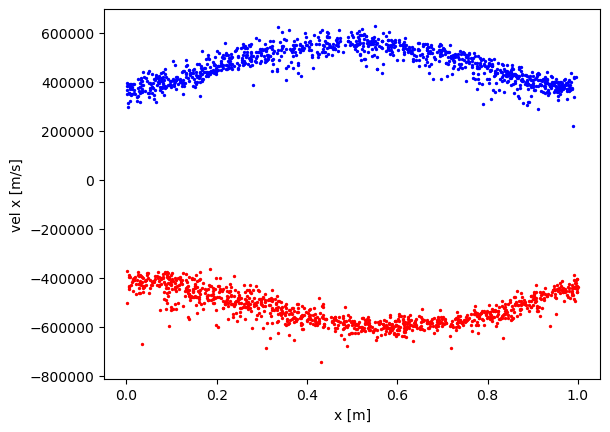

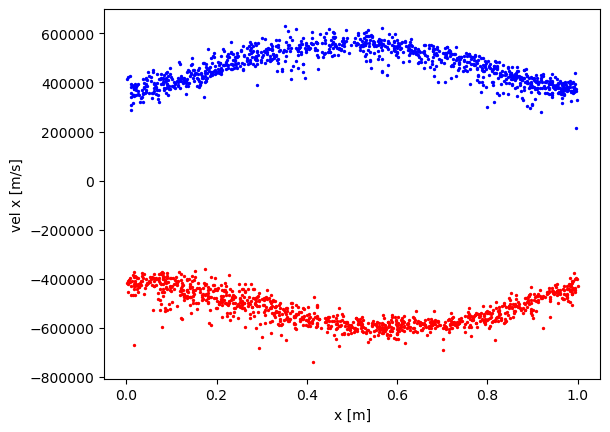

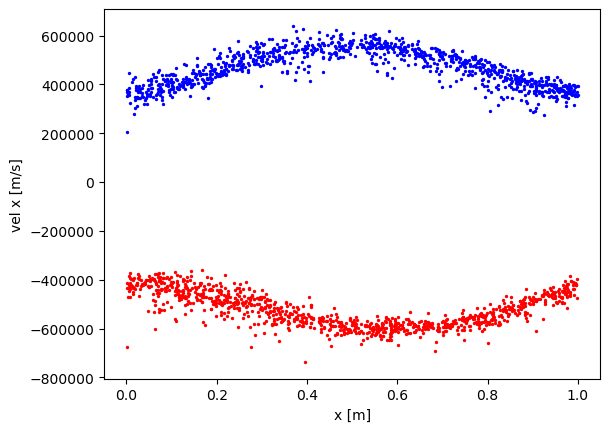

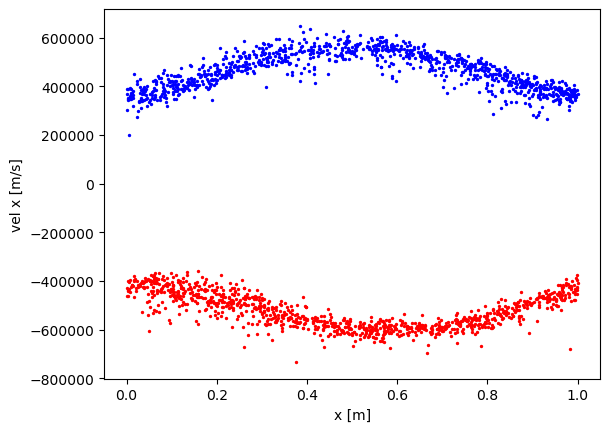

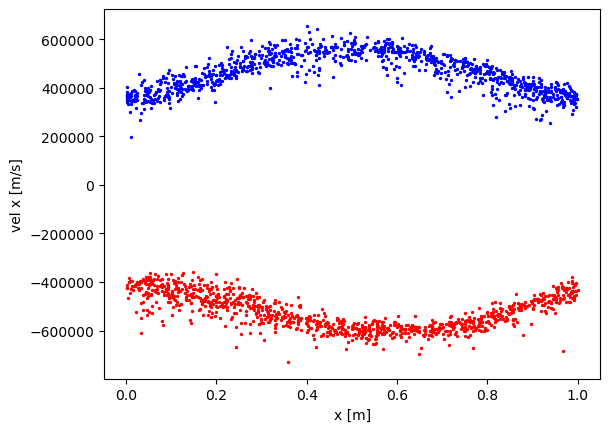

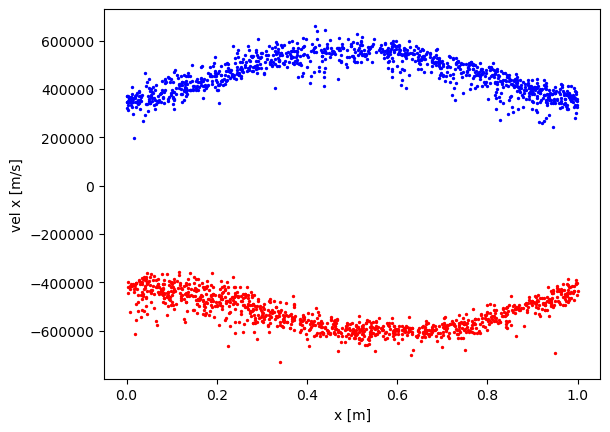

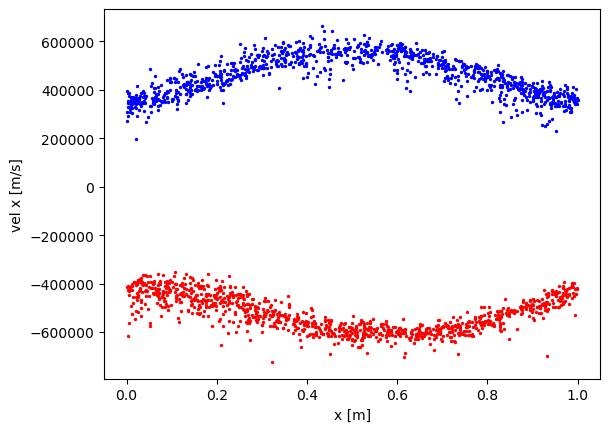

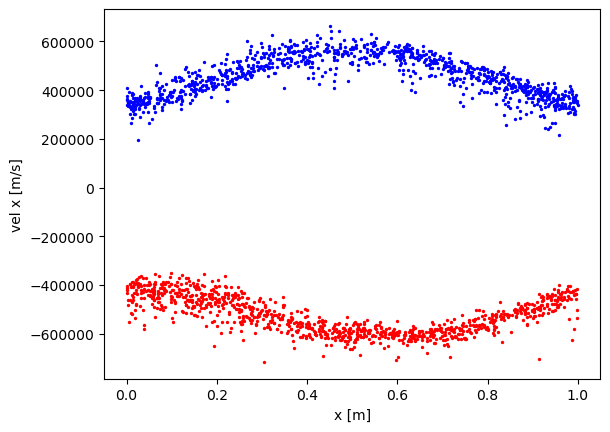

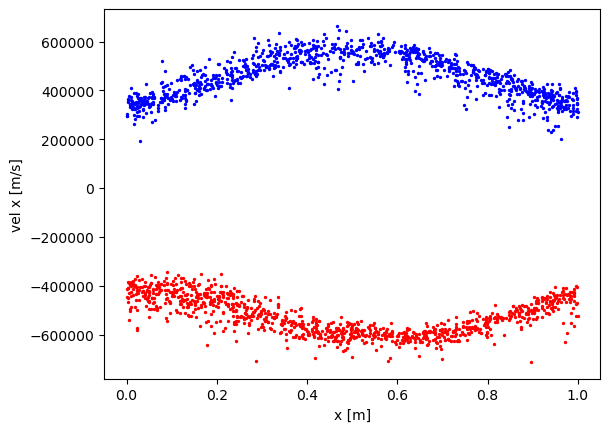

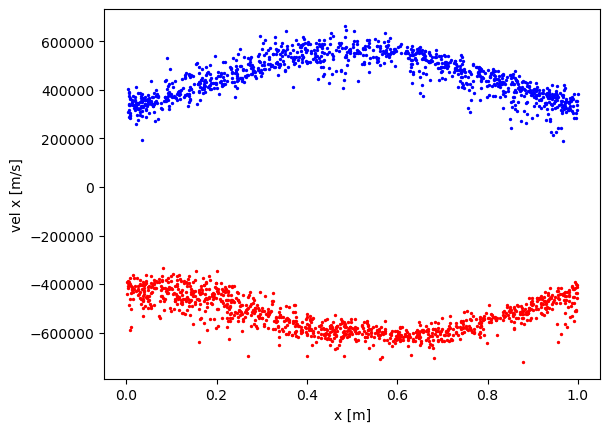

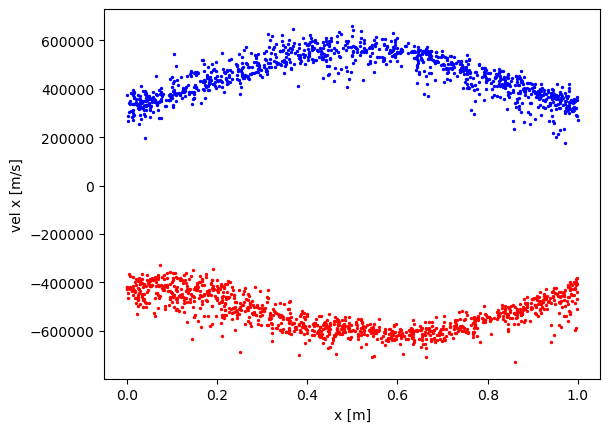

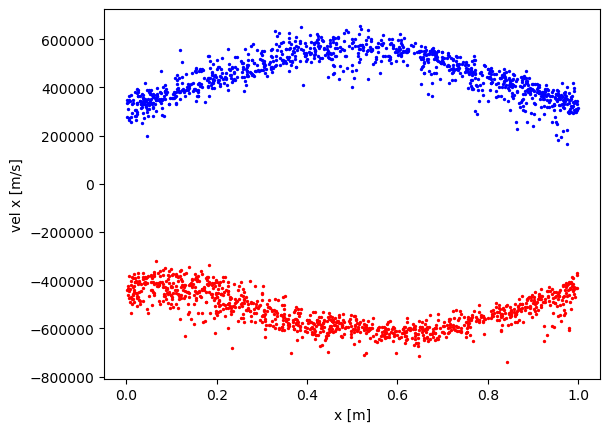

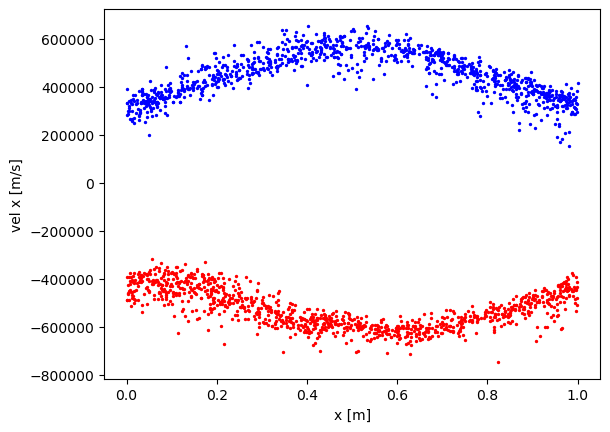

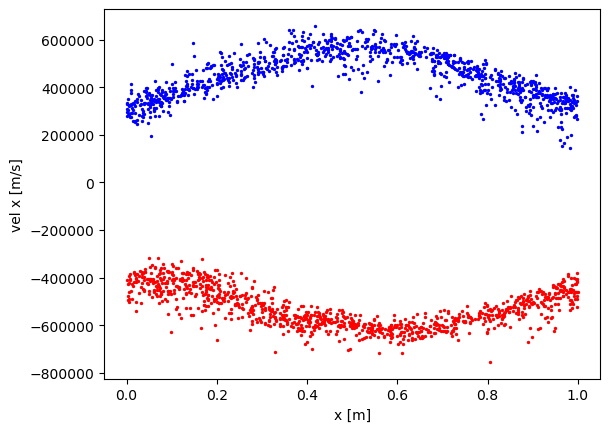

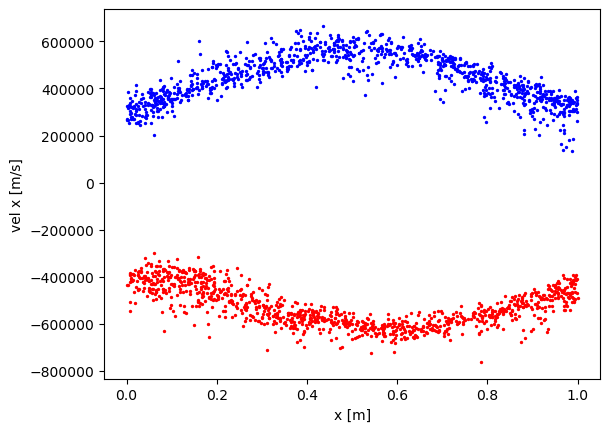

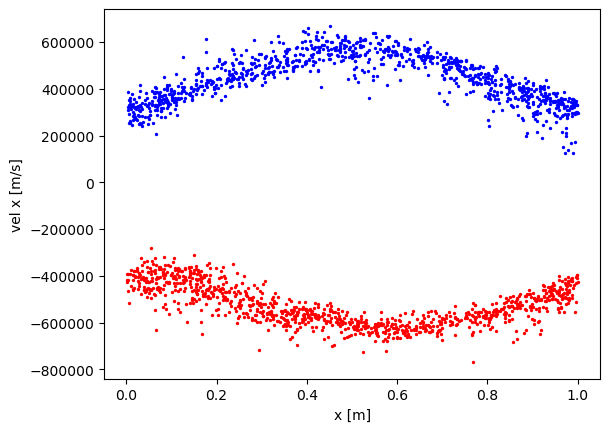

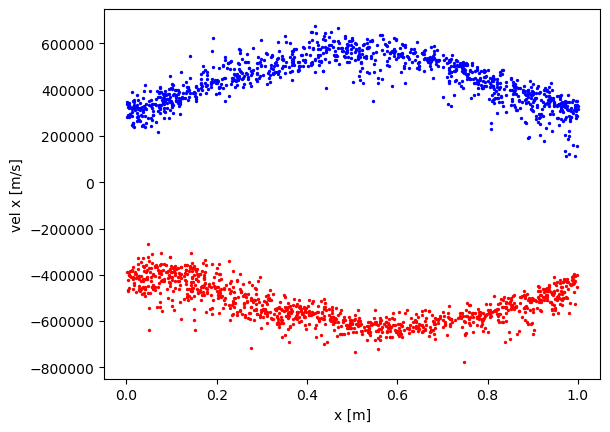

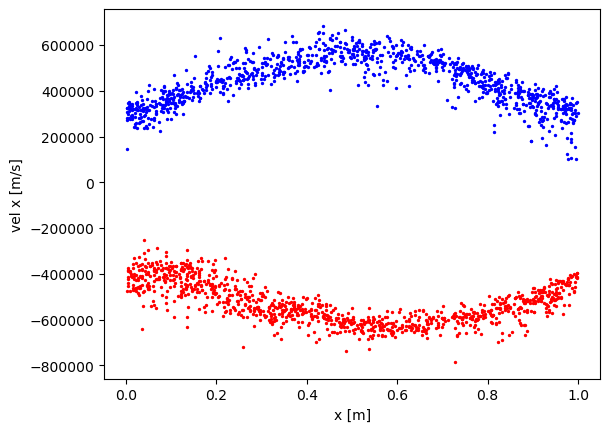

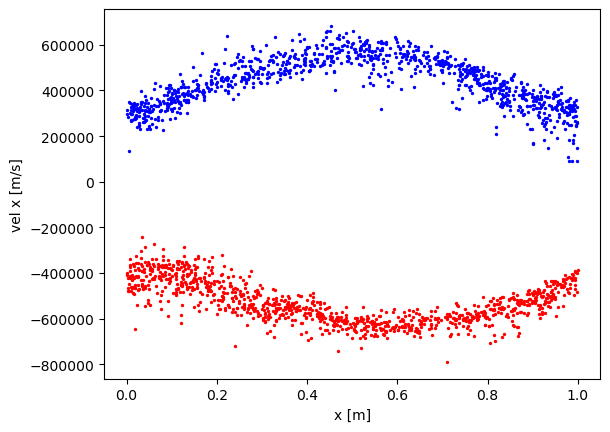

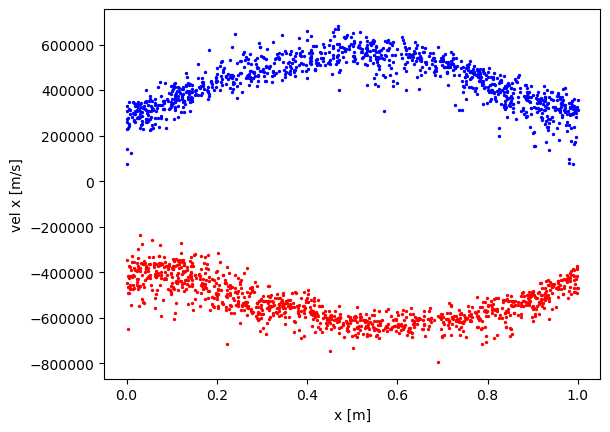

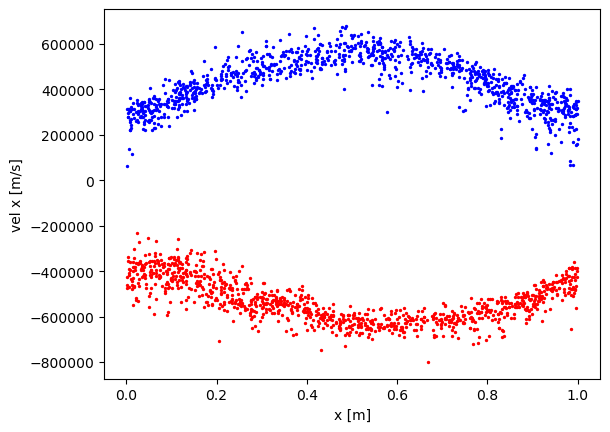

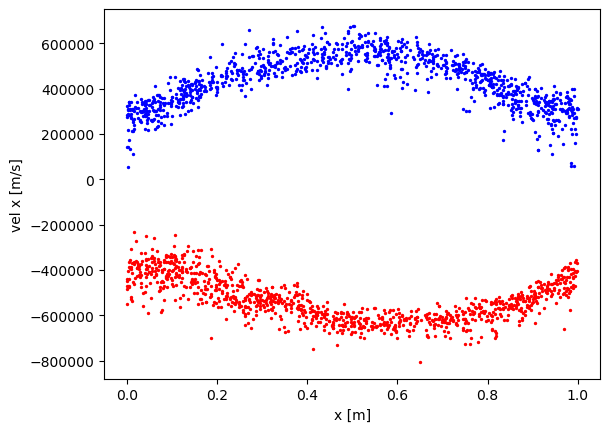

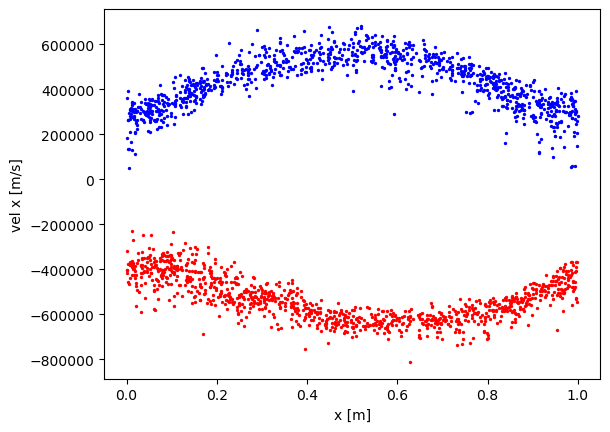

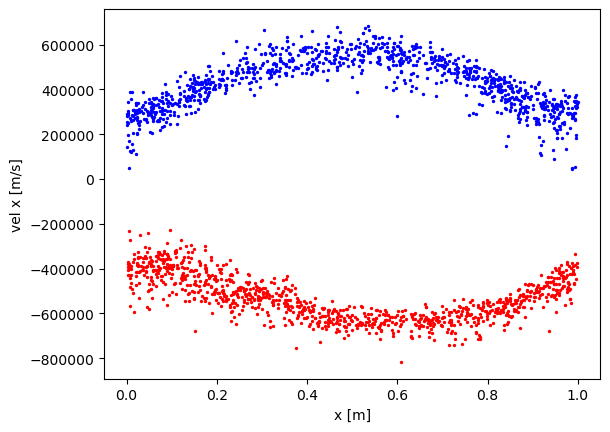

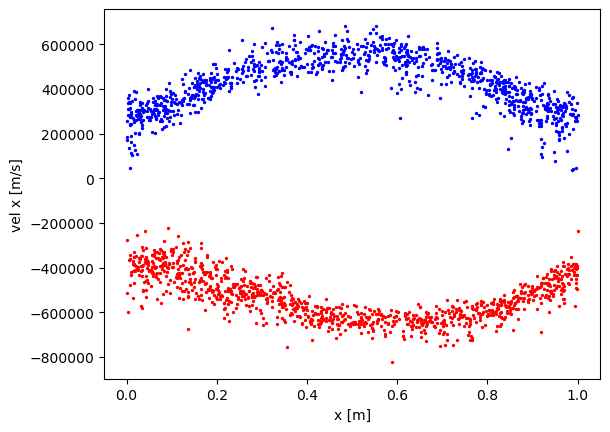

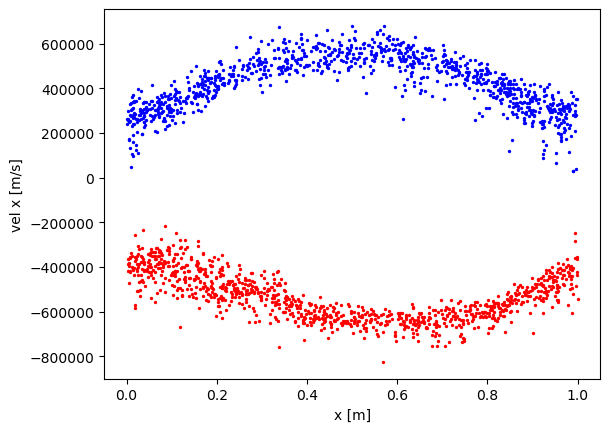

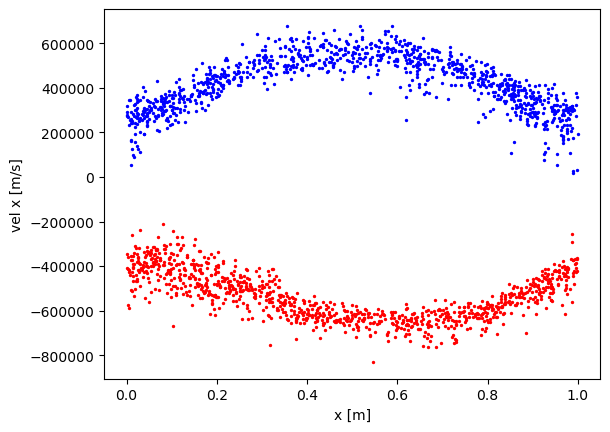

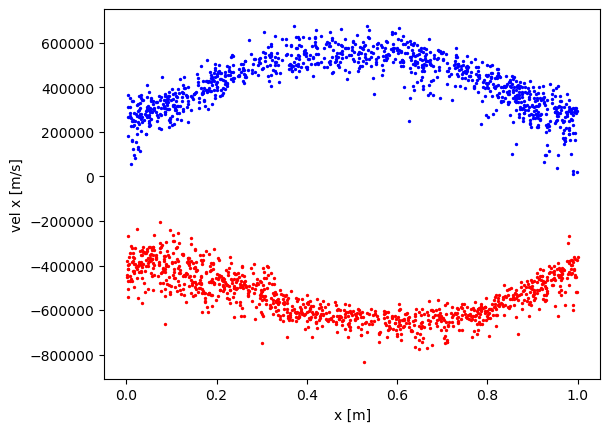

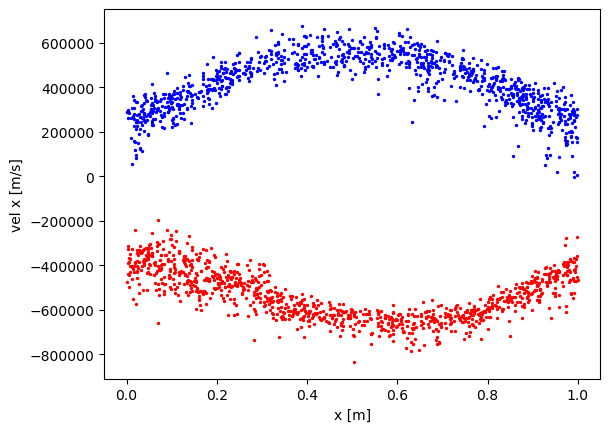

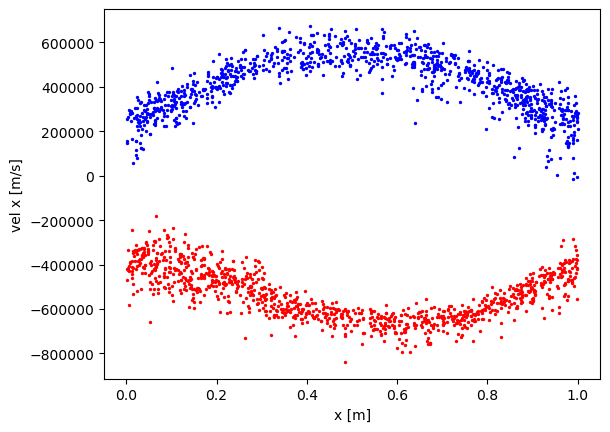

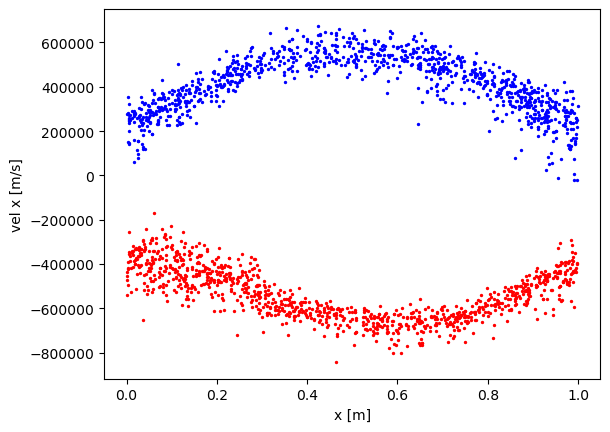

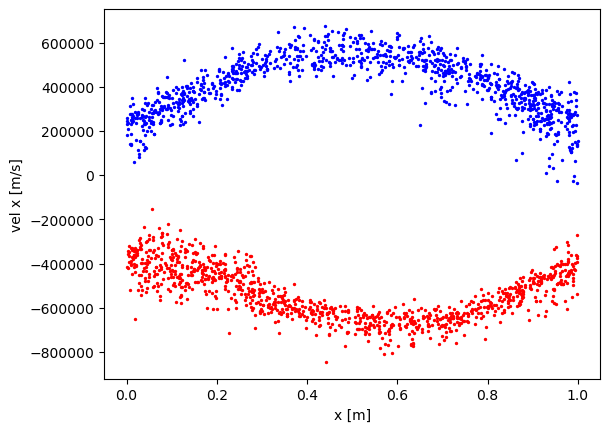

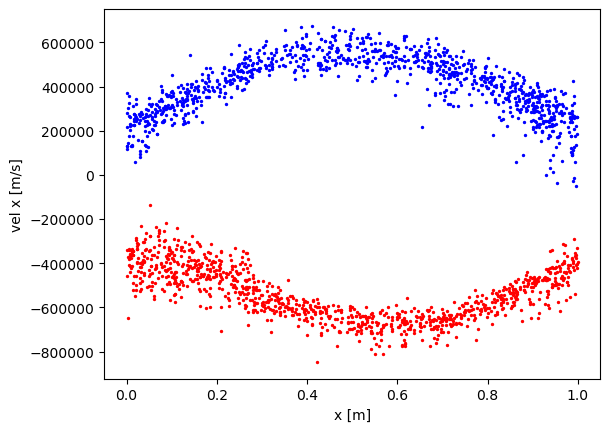

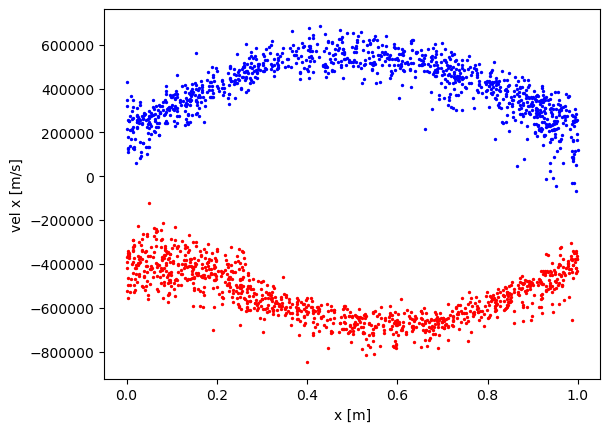

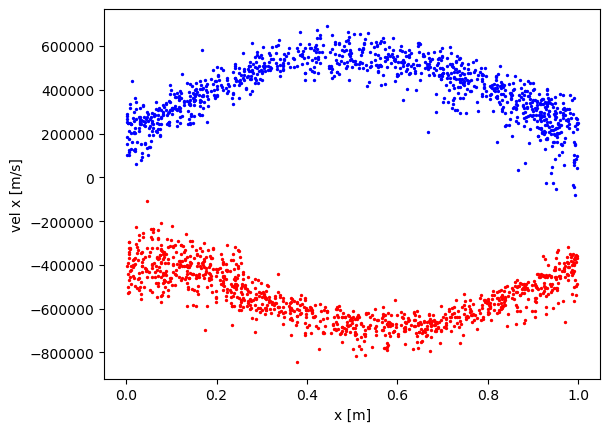

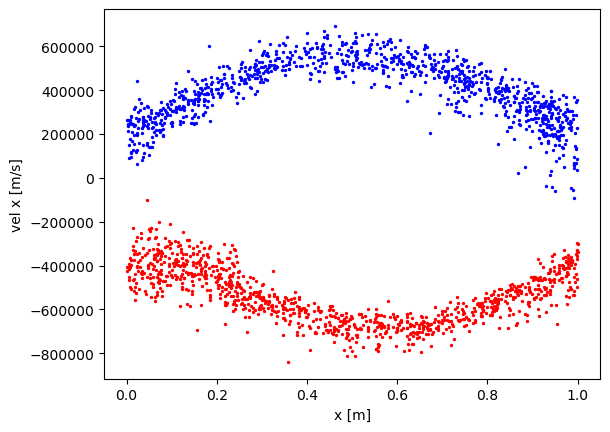

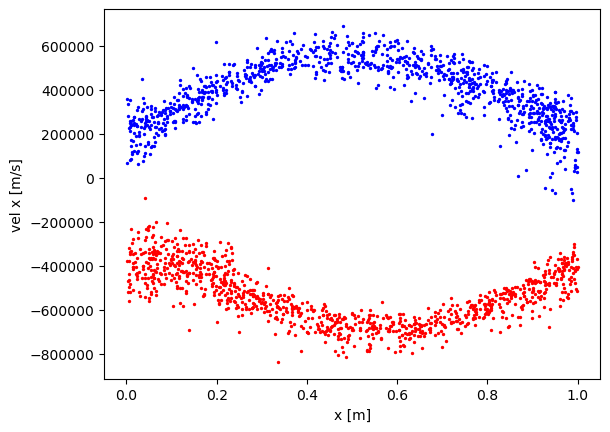

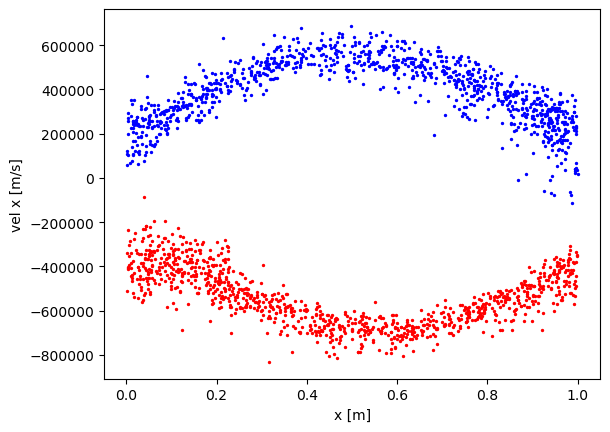

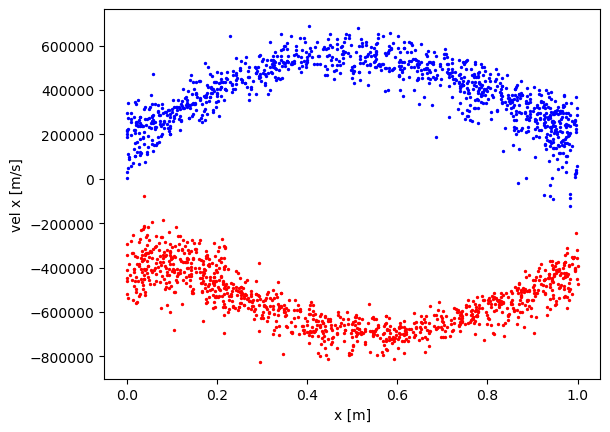

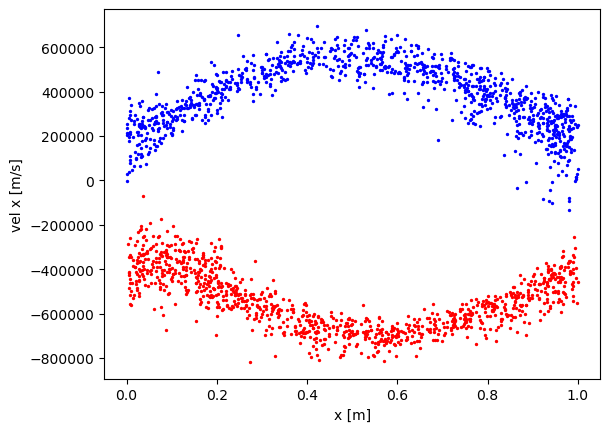

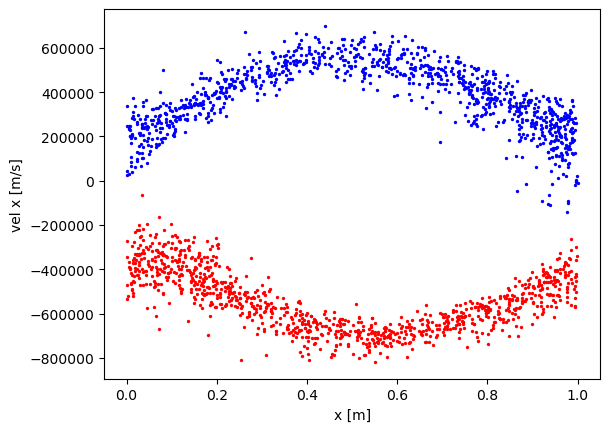

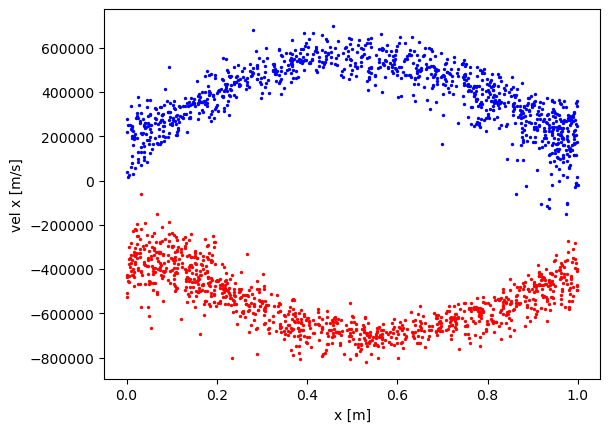

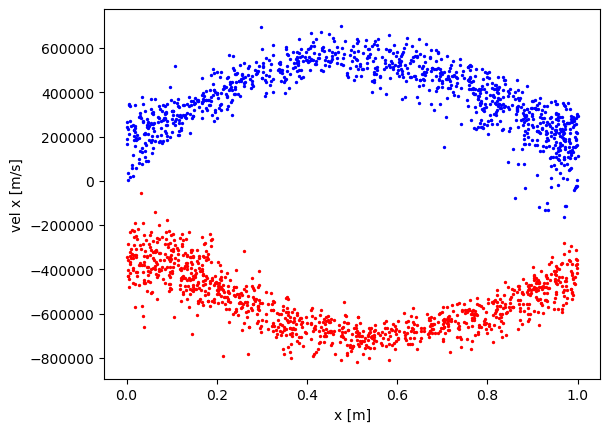

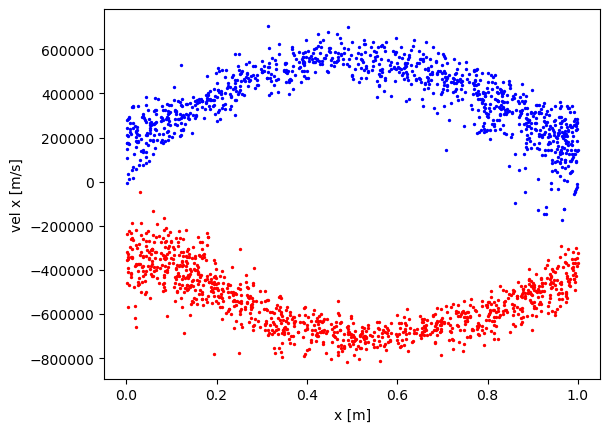

In [19]:
NP = 1024 #2048
d = 4.5e9
electrons, ions = generate_particles!(NP, d)

Δt = 1e-9
timesteps = 3000

historyxx = []
historyvel = []
EK = []
EK2 = []
EE = []
EP = []

for i = 1:timesteps
    println(i)
    PIC3D.timestep!(electrons, ions, 1)
    if i % 25 == 0
        plt.figure()
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 0],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 0], color="red", label="c = 1", s=2)
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 1],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 1], color="blue", label="c = 1", s=2)
        plt.xlabel("x [m]")
        plt.ylabel("vel x [m/s]")
        plt.show()
        push!(historyxx, [[ex...] for ex in electrons.x])
        push!(historyvel, [[ev...] for ev in electrons.v])
    end
    push!(EK, compute_EK_particles(electrons, ions))
    push!(EK2, compute_EK_particles2(electrons, ions, NP, d))
    push!(EE, compute_EP_field())
    push!(EP, compute_EP_potential())
end

In [38]:
NP = 2048 #2048
d = 4.5e9
electrons, ions = generate_particles!(NP, d)

@btime PIC3D.timestep!(electrons, ions, 1.0)

1.0986328125e6
GS failed to converge, L2 = 0.002645792414300206
GS failed to converge, L2 = 0.002645968977827824
GS failed to converge, L2 = 0.002673069495888779
GS failed to converge, L2 = 0.0026641239657480744
GS failed to converge, L2 = 0.002673194607289417
GS failed to converge, L2 = 0.0026731968220033517
GS failed to converge, L2 = 0.002664225905976906
GS failed to converge, L2 = 0.0026642753787388114
GS failed to converge, L2 = 0.002673192312714111
GS failed to converge, L2 = 0.002673108158050531
GS failed to converge, L2 = 0.0026820091522425575
GS failed to converge, L2 = 0.0026859379962831014
  1.472 s (41107 allocations: 3.14 MiB)


In [23]:
NP = 2048 #2048
d = 4.5e9
electrons, ions = generate_particles!(NP, d)

@btime PIC3D.timestep!(electrons, ions, 1.0)

1.0986328125e6
GS failed to converge, L2 = 0.0025255150859355207
GS failed to converge, L2 = 0.0025347248484086085
GS failed to converge, L2 = 0.0025440035994413455
GS failed to converge, L2 = 0.0025353496010877773
  7.598 s (41110 allocations: 3.14 MiB)


In [ ]:
NP = 2048 #2048
d = 4.5e9
electrons, ions = generate_particles!(NP, d)

Δt = 1e-9
timesteps = 3000

historyxx = []
historyvel = []
EK = []
EK2 = []
EE = []
EP = []

for i = 1:timesteps
    println(i)
    PIC3D.timestep_multigrid!(electrons, ions, 1.0)
    if i % 25 == 0
        plt.figure()
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 0],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 0], color="red", label="c = 1", s=2)
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 1],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 1], color="blue", label="c = 1", s=2)
        plt.xlabel("x [m]")
        plt.ylabel("vel x [m/s]")
        plt.show()
        push!(historyxx, [[ex...] for ex in electrons.x])
        push!(historyvel, [[ev...] for ev in electrons.v])
    end
    push!(EK, compute_EK_particles(electrons, ions))
    push!(EK2, compute_EK_particles2(electrons, ions, NP, d))
    push!(EE, compute_EP_field())
    push!(EP, compute_EP_potential())
end

1.0986328125e6
1
GS failed to converge, L2 = 0.0025326224558764178
2
GS failed to converge, L2 = 0.0025607361647687994
3
GS failed to converge, L2 = 0.00256182026447889
4
GS failed to converge, L2 = 0.0025630649024421877
5
GS failed to converge, L2 = 0.0025776666174013407
6
GS failed to converge, L2 = 0.002579377618647081
7
GS failed to converge, L2 = 0.002581269481617027
8
GS failed to converge, L2 = 0.0025899057687794303
9
GS failed to converge, L2 = 0.002591941232815804
10
GS failed to converge, L2 = 0.0025850382695570343
11
GS failed to converge, L2 = 0.0025746070304970346
12
GS failed to converge, L2 = 0.002576540494785482
13
GS failed to converge, L2 = 0.0025693155189965666
14
GS failed to converge, L2 = 0.002580071078863606
15
GS failed to converge, L2 = 0.002554710578431959
16
GS failed to converge, L2 = 0.002556251859834614
17
GS failed to converge, L2 = 0.002557876899860918
18
GS failed to converge, L2 = 0.002559532531722454
19
GS failed to converge, L2 = 0.002552402225004726

sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


GS failed to converge, L2 = 0.0022005580732363046
527
GS failed to converge, L2 = 0.002182544052482912
528
GS failed to converge, L2 = 0.002205004202424371
529
GS failed to converge, L2 = 0.002223087309433705
530
GS failed to converge, L2 = 0.0022213297253836227
531
GS failed to converge, L2 = 0.002193870035020523
532
GS failed to converge, L2 = 0.002184259170889995
533
GS failed to converge, L2 = 0.0021835751634271742
534
GS failed to converge, L2 = 0.0022276777324791047
535
GS failed to converge, L2 = 0.0022264158695628677
536
GS failed to converge, L2 = 0.0022249950407543105
537
GS failed to converge, L2 = 0.0022198007531625268
538
GS failed to converge, L2 = 0.0022213992026363333
539
GS failed to converge, L2 = 0.0022109505601679547
540
GS failed to converge, L2 = 0.0022005808156212517
541
GS failed to converge, L2 = 0.0022044868293563807
542
GS failed to converge, L2 = 0.00220278060052169
543
GS failed to converge, L2 = 0.002201009780796593
544
GS failed to converge, L2 = 0.002208

1.0986328125e6
1
GS failed to converge, L2 = 0.002645792414299869
2
GS failed to converge, L2 = 0.0026459689778274846
3
GS failed to converge, L2 = 0.0026730694958885647
4
GS failed to converge, L2 = 0.0026641239657482366
5
GS failed to converge, L2 = 0.002673194607289381
6
GS failed to converge, L2 = 0.002673196822003501
7
GS failed to converge, L2 = 0.0026642259059771853
8
GS failed to converge, L2 = 0.0026642753787389666
9
GS failed to converge, L2 = 0.0026731923127142547
10
GS failed to converge, L2 = 0.00267310815805045
11
GS failed to converge, L2 = 0.002682009152242478
12
GS failed to converge, L2 = 0.002685937996283351
13
GS failed to converge, L2 = 0.0026751718125194537
14
GS failed to converge, L2 = 0.0026754219224229773
15
GS failed to converge, L2 = 0.0026667822104009926
16
GS failed to converge, L2 = 0.002667262549608136
17
GS failed to converge, L2 = 0.002676745157589588
18
GS failed to converge, L2 = 0.002704154560578515
19
GS failed to converge, L2 = 0.00270444339172896

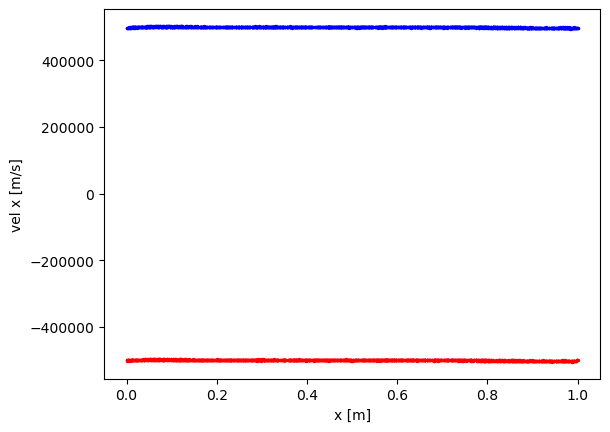

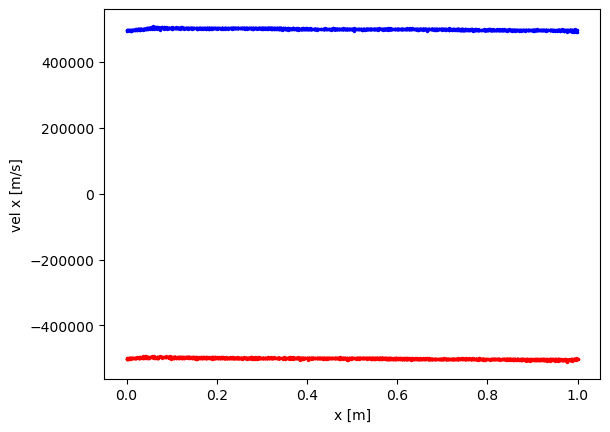

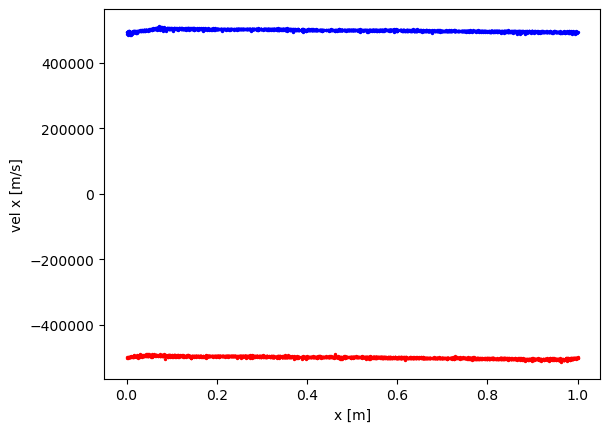

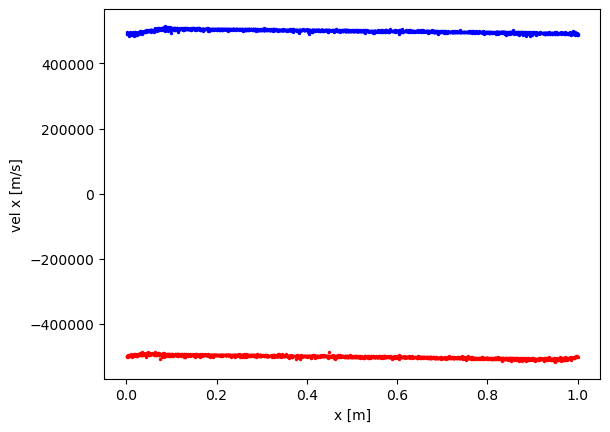

In [129]:
NP = 2048 #2048
d = 4.5e9
electrons, ions = generate_particles!(NP, d)

Δt = 1e-9
timesteps = 100

historyxx = []
historyvel = []
EK = []
EK2 = []
EE = []
EP = []

for i = 1:timesteps
    println(i)
    PIC3D.timestep!(electrons, ions, 1.0)
    if i % 25 == 0
        plt.figure()
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 0],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 0], color="red", label="c = 1", s=2)
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 1],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 1], color="blue", label="c = 1", s=2)
        plt.xlabel("x [m]")
        plt.ylabel("vel x [m/s]")
        plt.show()
        push!(historyxx, [[ex...] for ex in electrons.x])
        push!(historyvel, [[ev...] for ev in electrons.v])
    end
    push!(EK, compute_EK_particles(electrons, ions))
    push!(EK2, compute_EK_particles2(electrons, ions, NP, d))
    push!(EE, compute_EP_field())
    push!(EP, compute_EP_potential())
end

1.0986328125e6
1
GS failed to converge, L2 = 0.002645802733115265
2
GS failed to converge, L2 = 0.0026459796396390207
3
GS failed to converge, L2 = 0.0026730811030247223
4
GS failed to converge, L2 = 0.002664136634661723
5
GS failed to converge, L2 = 0.0026732091551245085
6
GS failed to converge, L2 = 0.0026732140776757132
7
GS failed to converge, L2 = 0.0026642450941170904
8
GS failed to converge, L2 = 0.00266429782556715
9
GS failed to converge, L2 = 0.002673219457276672
10
GS failed to converge, L2 = 0.002673139318515591
11
GS failed to converge, L2 = 0.002682045833831452
12
GS failed to converge, L2 = 0.002685979906695252
13
GS failed to converge, L2 = 0.0026752162307852483
14
GS failed to converge, L2 = 0.0026754687197348068
15
GS failed to converge, L2 = 0.0026668319154540474
16
GS failed to converge, L2 = 0.0026673170785962495
17
GS failed to converge, L2 = 0.0026768093228671306
18
GS failed to converge, L2 = 0.002704227497633813
19
GS failed to converge, L2 = 0.0027045242155373

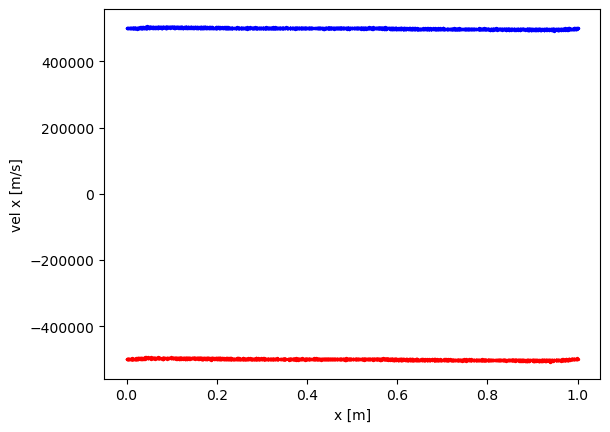

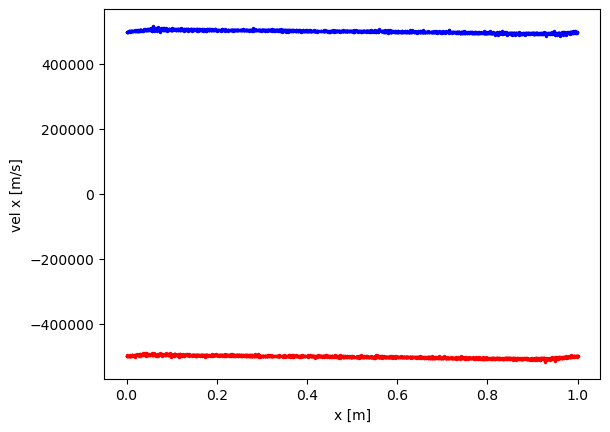

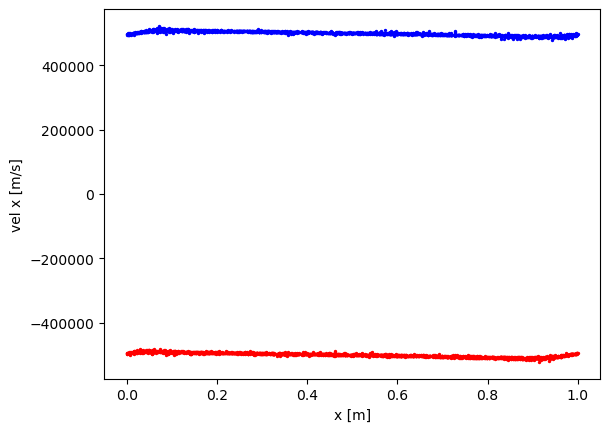

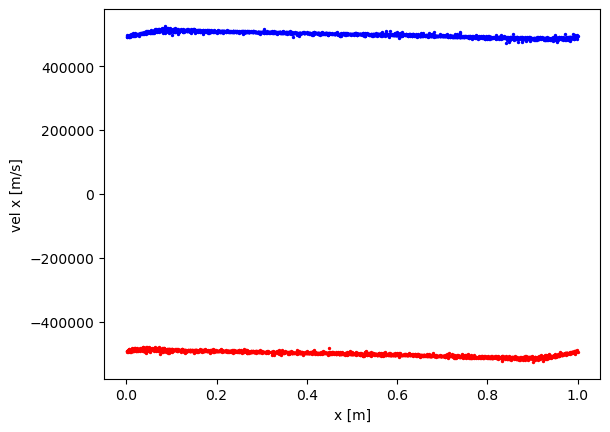

In [11]:
NP = 2048 #2048
d = 4.5e9
electrons, ions = generate_particles!(NP, d)

Δt = 1e-9
timesteps = 3000

historyxx = []
historyvel = []
EK = []
EK2 = []
EE = []
EP = []

for i = 1:timesteps
    println(i)
    PIC3D.timestep!(electrons, ions, 1.0)
    if i % 25 == 0
        plt.figure()
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 0],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 0], color="red", label="c = 1", s=2)
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 1],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 1], color="blue", label="c = 1", s=2)
        plt.xlabel("x [m]")
        plt.ylabel("vel x [m/s]")
        plt.show()
        push!(historyxx, [[ex...] for ex in electrons.x])
        push!(historyvel, [[ev...] for ev in electrons.v])
    end
    push!(EK, compute_EK_particles(electrons, ions))
    push!(EK2, compute_EK_particles2(electrons, ions, NP, d))
    push!(EE, compute_EP_field())
    push!(EP, compute_EP_potential())
end

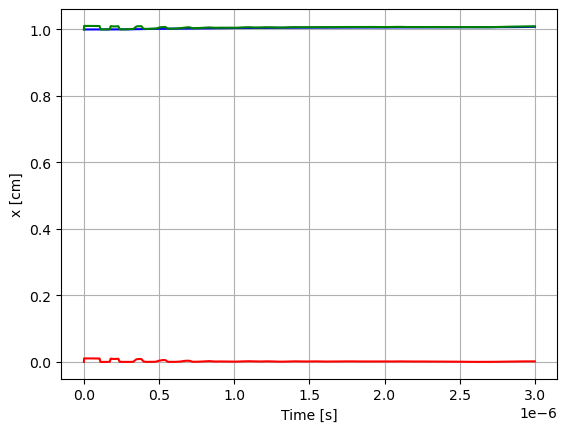

PyObject Text(24.000000000000007, 0.5, 'x [cm]')

In [34]:
fig = plt.figure()
times = [i*Δt for i=1:3000]
plt.plot(times, EE ./ EK[1], linestyle="solid", color="red")
plt.plot(times, EK ./ EK[1], linestyle="solid", color="blue")
plt.plot(times, EE ./ EK[1] + EK ./ EK[1], linestyle="solid", color="green")
#plt.plot(times, EP ./ EK[1], linestyle="solid", color="black")
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("x [cm]")

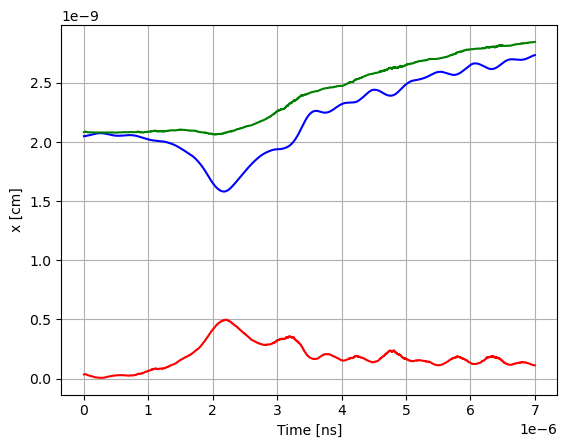

PyObject Text(24.000000000000007, 0.5, 'x [cm]')

In [30]:
fig = plt.figure()
times = [i*Δt for i=1:7000]
plt.plot(times, EE , linestyle="solid", color="red")
plt.plot(times, EK , linestyle="solid", color="blue")
plt.plot(times, EE + EK , linestyle="solid", color="green")
#plt.plot(times, EP ./ EK[1], linestyle="solid", color="black")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")

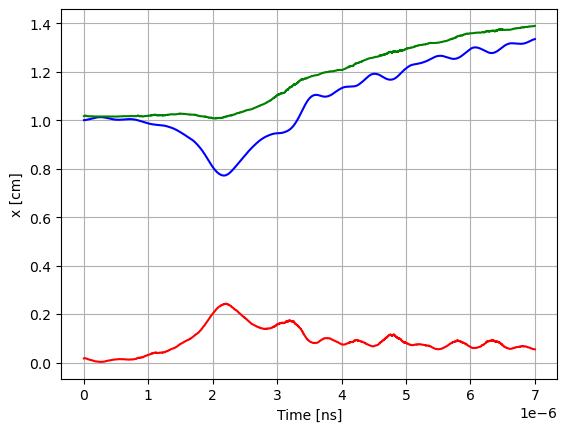

PyObject Text(24.000000000000007, 0.5, 'x [cm]')

In [29]:
fig = plt.figure()
times = [i*Δt for i=1:7000]
plt.plot(times, EE ./ EK[1], linestyle="solid", color="red")
plt.plot(times, EK ./ EK[1], linestyle="solid", color="blue")
plt.plot(times, EE ./ EK[1] + EK ./ EK[1], linestyle="solid", color="green")
#plt.plot(times, EP ./ EK[1], linestyle="solid", color="black")
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("x [cm]")

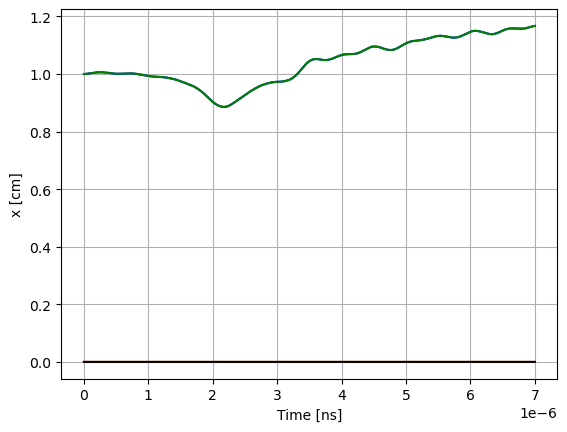

PyObject Text(24.000000000000007, 0.5, 'x [cm]')

In [22]:
fig = plt.figure()
times = [i*Δt for i=1:7000]
plt.plot(times, EE ./ EK2[1], linestyle="solid", color="red")
plt.plot(times, EK2 ./ EK2[1], linestyle="solid", color="blue")
plt.plot(times, EE ./ EK2[1] + EK2 ./ EK2[1], linestyle="solid", color="green")
plt.plot(times, EP ./ EK2[1], linestyle="solid", color="black")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")

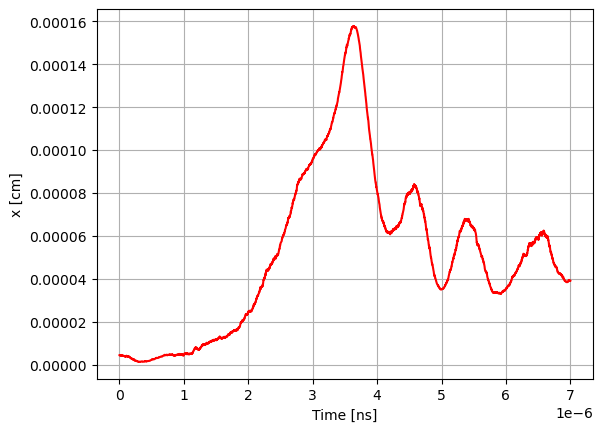

PyObject Text(24.0, 0.5, 'x [cm]')

In [66]:
fig = plt.figure()
times = [i*Δt for i=1:7000]
plt.plot(times, EE ./ EK[1], linestyle="solid", color="red")
#plt.plot(times, EK ./ EK[1], linestyle="solid", color="blue")
#plt.plot(times, EE ./ EK[1] + EK ./ EK[1], linestyle="solid", color="green")
#plt.plot(times, EP ./ EK[1], linestyle="solid", color="black")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")

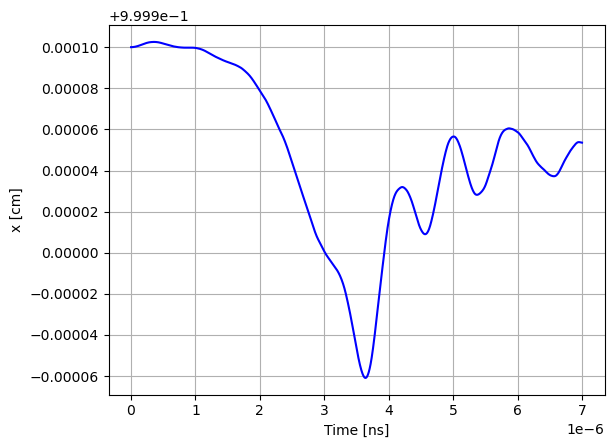

PyObject Text(24.0, 0.5, 'x [cm]')

In [67]:
fig = plt.figure()
times = [i*Δt for i=1:7000]
#plt.plot(times, EE ./ EK[1], linestyle="solid", color="red")
plt.plot(times, EK ./ EK[1], linestyle="solid", color="blue")
#plt.plot(times, EE ./ EK[1] + EK ./ EK[1], linestyle="solid", color="green")
#plt.plot(times, EP ./ EK[1], linestyle="solid", color="black")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")